In [7]:
%config Completer.use_jedi = False
import os

import numpy as np
import pandas as pd

import anndata
import scanpy as sc

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from matplotlib import gridspec
import matplotlib as mpl
import seaborn as sns

from collections import defaultdict
import random
    
print('Load interaction') 
fn_int = '/home/yike/phd/dengue/data/interaction_source_file/interactions_DB.tsv'
interactions = pd.read_csv(fn_int, sep=',')[['gene_name_a', 'gene_name_b']]

print('Load high-quality cells only')
fn_h5ad = '/home/yike/phd/dengue/data/mergedata_20210519_hq_cts.h5ad'
adata = sc.read_h5ad(fn_h5ad)
print('normalize data to CPM (counts per million)')
sc.pp.normalize_total(adata, target_sum=1e6)
        
print('Restrict to interaction genes')
genes = np.unique(interactions)
genes = [i for i in genes if i in adata.var_names] # genes = genes - ['CCL3L3', 'CCL4L1', 'CCN6', 'KIR3DS1', 'YARS1']
adatag = adata[:, genes]

Load interaction
Load high-quality cells only
normalize data to CPM (counts per million)
Restrict to interaction genes


In [2]:
adata_children = adata[adata.obs['dataset'] == 'child']
adata_adults = adata[adata.obs['dataset'] == 'adult']
from adata_utilis import split_adata
print('split adata to [sick/condition, dataset]')
adata_dic = split_adata(adata)

split adata to [sick/condition, dataset]


In [5]:
print("calculate 'Median of pairs' and 'Frac of pairs'")
from log2_FC_functions import log2_FC_all

gbs = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

adata_gb = {}
log2_fc_all = {}
log2_fc_ave = pd.DataFrame([])

for gb in gbs:
    adata_gb[gb] = adata[adata.obs['cell_type'] == gb]
    if gb == 'cDCs':
        print('if cell type is cDCs, exclude IDs with < 5 cDcs')
        adata_gb[gb] = adata_gb[gb][ ~ adata_gb[gb].obs['ID'].isin(['1_140_01', '5_193_01'])]
    
    log2_fc_all[gb] = log2_FC_all(genes, adata_gb[gb], 'S_dengue', 'dengue', 'child')[1]
    log2_fc_all[gb]['cell_type']=[gb]*log2_fc_all[gb].shape[0]
    log2_fc_ave = pd.concat([log2_fc_ave, log2_fc_all[gb]])

log2_fc_ave['gene'] = log2_fc_ave.index.values
log2_fc_ave = log2_fc_ave.set_index('cell_type')

calculate 'Median of pairs' and 'Frac of pairs'
if cell type is cDCs, exclude IDs with < 5 cDcs


In [6]:
print("calculate 'Ave exp' and 'Exp Frac'")

adatag_children = adatag[adatag.obs['dataset'] == 'child']
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue', 'DWS', 'Healthy']

adatag_ch_ct_cd = {}
for cell_type in cell_types:
    if cell_type == 'cDCs':
        print('if cell type is cDCs, exclude IDs with < 5 cDcs')
        adatag_children = adatag_children[ ~ adatag_children.obs['ID'].isin(['1_140_01', '5_193_01'])]
    for condition in conditions:
        adatag_ch_ct_cd[(cell_type, condition)] = adatag_children[adatag_children.obs['cell_type'] == cell_type][adatag_children[adatag_children.obs['cell_type'] == cell_type].obs['Condition'] == condition] 

exp_fra = {}
for key in adatag_ch_ct_cd.keys():
    fra = (adatag_ch_ct_cd[key].X > 0).toarray().mean(axis=0)
    exp_fra[key] = pd.DataFrame(fra, index=adatag_ch_ct_cd[key].var.index, columns=[['exp_fra']])

ave_exp = {}
for key in adatag_ch_ct_cd.keys():
    exp = adatag_ch_ct_cd[key].X.toarray().mean(axis=0)
    ave_exp[key] = pd.DataFrame(exp, index=adatag_ch_ct_cd[key].var.index, columns=[['ave_exp']])

fra = pd.DataFrame([])
exp = pd.DataFrame([])
for key in exp_fra.keys():
    exp_fra[key]['cell_type'] = [key[0]]*(exp_fra[key].shape[0])
    exp_fra[key]['condition'] = [key[1]]*(exp_fra[key].shape[0])
    fra = pd.concat([fra, exp_fra[key]])
  
    ave_exp[key]['cell_type'] = [key[0]]*(ave_exp[key].shape[0])
    ave_exp[key]['condition'] = [key[1]]*(ave_exp[key].shape[0])
    exp = pd.concat([exp, ave_exp[key]])
    
fra['gene'] = fra.index
fra.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/fra.tsv')

exp['gene'] = exp.index
exp.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/exp.tsv')

calculate 'Ave exp' and 'Exp Frac'
if cell type is cDCs, exclude IDs with < 5 cDcs


In [7]:
print("add statistic and pvalue by KS test to 'log2_fc'")

log2_fc = log2_fc_ave.set_index([log2_fc_ave.index, 'gene'])
pvalue = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/inters/inter_genes_pvalue.tsv', index_col=['cell_type', 'Unnamed: 0'])

pvalue = pvalue.loc[log2_fc.index]

log2_fc['statistic'] = pvalue['statistic']
log2_fc['pvalue'] = pvalue['pvalue']

add statistic and pvalue by KS test to 'log2_fc'


In [8]:
print("add 'Ave exp' and 'Exp frac' of SD and D to 'log2_fc'")

fra = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/fra.tsv', index_col=['cell_type', 'gene', 'condition'])
exp = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/exp.tsv', index_col=['cell_type', 'gene', 'condition'])

fra_SD = fra.loc[[(idx[0], idx[1], 'S_dengue') for idx in log2_fc.index]]
fra_D = fra.loc[[(idx[0], idx[1], 'dengue') for idx in log2_fc.index]]

exp_SD = exp.loc[[(idx[0], idx[1], 'S_dengue') for idx in log2_fc.index]]
exp_D = exp.loc[[(idx[0], idx[1], 'dengue') for idx in log2_fc.index]]

log2_fc['SD_exp_frac'] = fra_SD['exp_fra'].tolist()
log2_fc['D_exp_frac'] = fra_D['exp_fra'].tolist()
log2_fc['SD_ave_exp'] = exp_SD['ave_exp'].tolist()
log2_fc['D_ave_exp'] = exp_D['ave_exp'].tolist()

log2_fc.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/log2_fc.tsv')

add 'Ave exp' and 'Exp frac' of SD and D to 'log2_fc'


In [113]:
print('get the number of interactions at SD and D, threshold: exp frac >= 2%')

inters_im = defaultdict(list)
cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']
conditions = ['S_dengue', 'dengue']

exp_frac = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/exp.tsv', index_col=['cell_type', 'condition'])

for _, row in interactions.iterrows():
    ga = row['gene_name_a']
    gb = row['gene_name_b']
    if (ga not in genes) | (gb not in genes):
        continue
    for condition in conditions:
        for ct1 in cell_types:
            for ct2 in cell_types:
                ga_ct1 = exp_frac.loc[(ct1, condition)][exp_frac.loc[(ct1, condition)]['gene'] == ga]['ave_exp'][0]
                gb_ct2 = exp_frac.loc[(ct2, condition)][exp_frac.loc[(ct2, condition)]['gene'] == gb]['ave_exp'][0]
                
                gb_ct1 = exp_frac.loc[(ct1, condition)][exp_frac.loc[(ct1, condition)]['gene'] == gb]['ave_exp'][0]
                ga_ct2 = exp_frac.loc[(ct2, condition)][exp_frac.loc[(ct2, condition)]['gene'] == ga]['ave_exp'][0]

                if (ga_ct1 >= 0.05) & (gb_ct2 >= 0.05):
                    inters_im[(ct1, ct2, condition)].append([ga, gb])
                if (ga_ct2 >= 0.05) & (gb_ct1 >= 0.05):
                    inters_im[(ct1, ct2, condition)].append([gb, ga])
                
for key in inters_im.keys():
    if key[0] == key[1]:
        inters_im[key] = inters_im[key][::2]
        
its = pd.DataFrame([])
for key in inters_im.keys():
    inter_im = pd.DataFrame(inters_im[key], columns=['ga', 'gb'])
    inter_im['cell_type1'] = [key[0]] * len(inters_im[key])
    inter_im['cell_type2'] = [key[1]] * len(inters_im[key])
    inter_im['condition'] = [key[2]] * len(inters_im[key])
    
    its = pd.concat([its, inter_im])

its.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/inters_cd_005.tsv')
#######################################################################

get the number of interactions at SD and D, threshold: exp frac >= 2%


<ipython-input-113-bd98af6cd5fa>:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  ga_ct1 = exp_frac.loc[(ct1, condition)][exp_frac.loc[(ct1, condition)]['gene'] == ga]['ave_exp'][0]
<ipython-input-113-bd98af6cd5fa>:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  gb_ct2 = exp_frac.loc[(ct2, condition)][exp_frac.loc[(ct2, condition)]['gene'] == gb]['ave_exp'][0]
<ipython-input-113-bd98af6cd5fa>:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  gb_ct1 = exp_frac.loc[(ct1, condition)][exp_frac.loc[(ct1, condition)]['gene'] == gb]['ave_exp'][0]
<ipython-input-113-bd98af6cd5fa>:21: PerformanceWarning: indexing past lexsort depth may impact performance.
  ga_ct2 = exp_frac.loc[(ct2, condition)][exp_frac.loc[(ct2, condition)]['gene'] == ga]['ave_exp'][0]


In [114]:
inters_im = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/inters_cd_005.tsv', index_col=['cell_type1', 'cell_type2', 'condition'])
intern_im = {}
for key in inters_im.index:
    intern_im[key] = inters_im.loc[key].shape[0]
    
colors_im = {}
norm_intern_im = {}
vmin, vmax = 150, 1500

for key in intern_im.keys():
    norm_intern_im[key] = (min(intern_im[(key)], vmax) - vmin)/(vmax - vmin)
    colors_im[key] = plt.cm.get_cmap('plasma')(norm_intern_im[key])
#######################################################################
print('get the heatmap showing the number of interactions at SD and D')
it_im = pd.DataFrame([])
ls_im = defaultdict(list)

cell_types = ['B_cells', 'Monocytes', 'NK_cells', 'Plasmablasts', 'T_cells', 'cDCs', 'pDCs']

for a in range(len(cell_types)):
    for b in range(len(cell_types)):
        ls_im[cell_types[a]].append(intern_im[(cell_types[a], cell_types[b], 'S_dengue')])
    it_im[cell_types[a]] = ls_im[cell_types[a]]
    
it_im.index = pd.Index(cell_types)  
# lower left: down, upper right: up

from scipy.spatial.distance import pdist 
distance = pdist(it_im.values) 

from scipy.cluster.hierarchy import linkage, leaves_list
lkg = linkage(distance, optimal_ordering=True)
best_order_im = leaves_list(lkg) 

it_im_new = it_im.iloc[best_order_im]
cts_im_op = list(it_im_new.index)

<ipython-input-114-615af5fef1fe>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  intern_im[key] = inters_im.loc[key].shape[0]


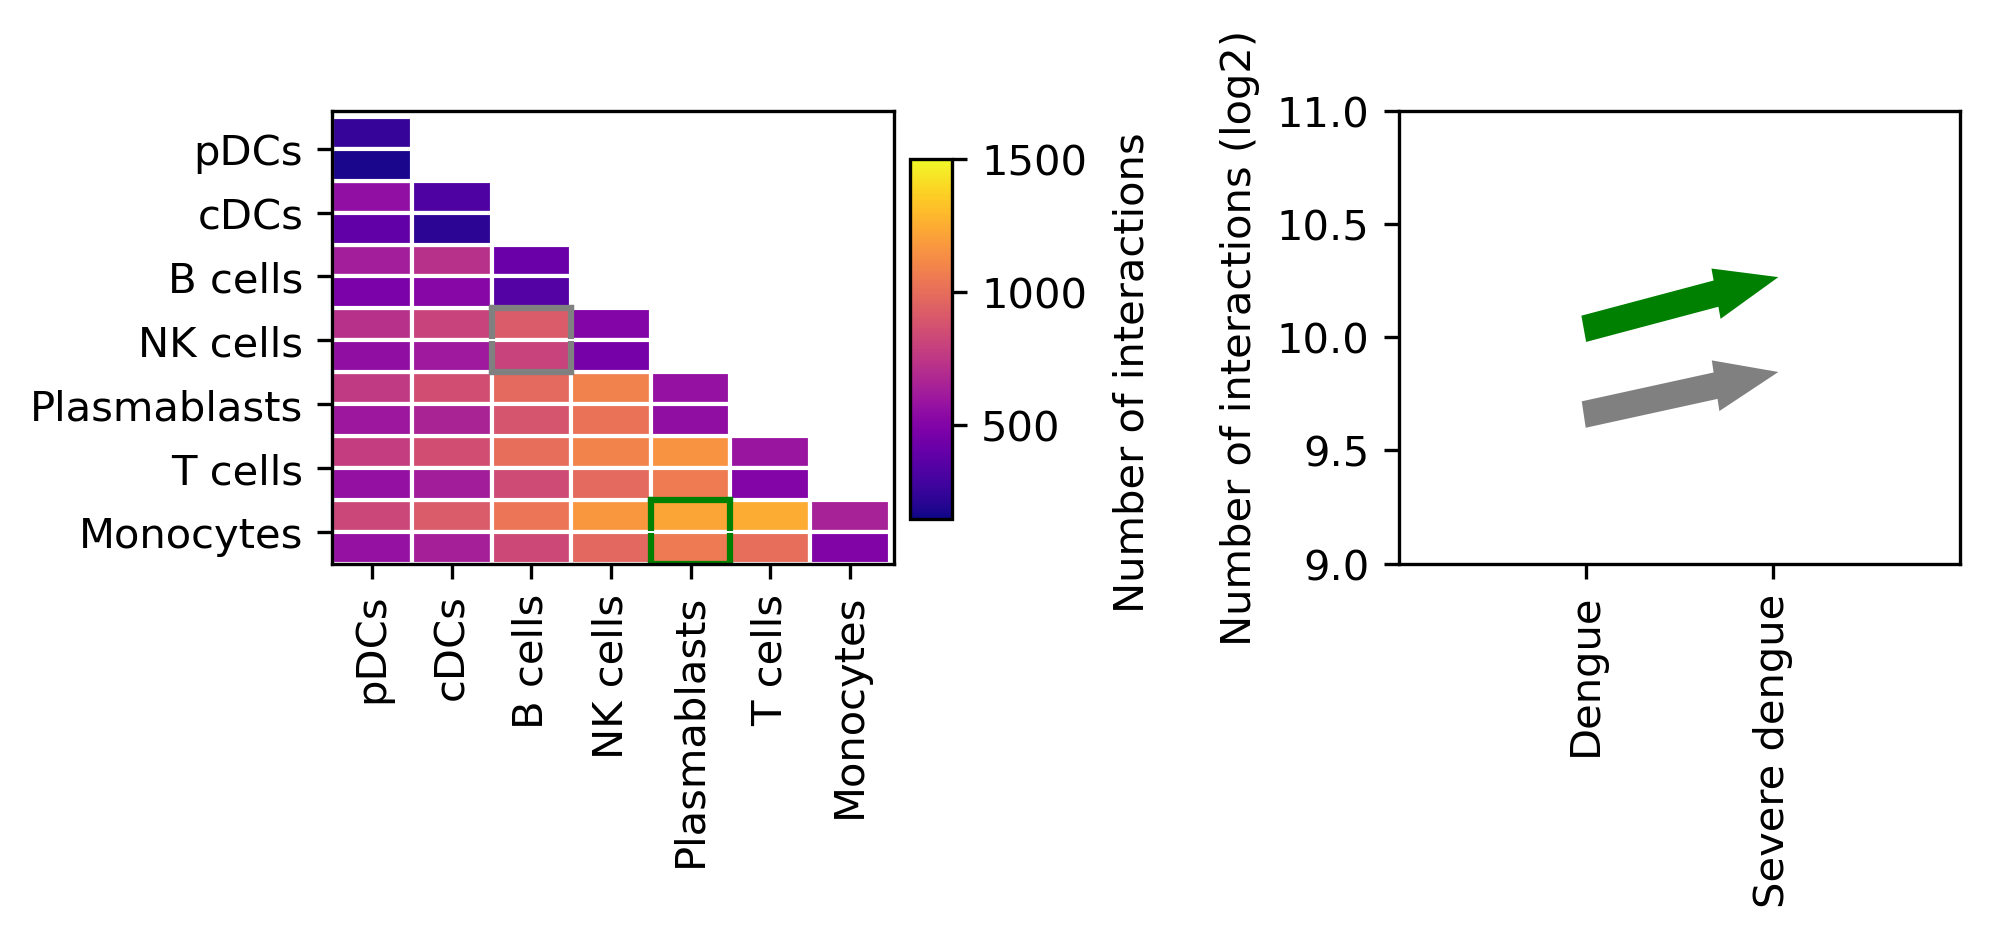

In [122]:
####################################### plot
fig, axs = plt.subplots(1, 2, figsize=[7, 2], dpi=300) 
plt.subplots_adjust(wspace=0.9)

###############################
for a in range(len(cts_im_op)):
    for b in range(len(cts_im_op)):
        axs[0].axhline(b+0.5, c='white', lw=0.4)
        
        if a+b <= 6:
            dots1 = [[a, b+0.5],
                    [a+1, b+0.5],
                    [a+1, b+1],
                    [a, b+1],
            ]
            e1 = mpatches.Polygon(np.array(dots1), facecolor=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'S_dengue')], edgecolor='white')
            axs[0].add_patch(e1)

            dots2 = [[a, b],
                    [a+1, b],
                    [a+1, b+0.5],
                    [a, b+0.5],
            ]
            e2 = mpatches.Polygon(np.array(dots2), facecolor=colors_im[(list(reversed(cts_im_op))[a], cts_im_op[b], 'dengue')], edgecolor='white')
            axs[0].add_patch(e2)
            
            if (list(reversed(cts_im_op))[a], cts_im_op[b]) == ('Plasmablasts', 'Monocytes'):
                axs[0].plot([a, a+1], [b, b], color='green')
                axs[0].plot([a+1, a+1], [b, b+1], color='green')
                axs[0].plot([a, a+1], [b+1, b+1], color='green')
                axs[0].plot([a, a], [b, b+1], color='green')
                
            elif (list(reversed(cts_im_op))[a], cts_im_op[b]) == ('B_cells', 'NK_cells'):
                axs[0].plot([a, a+1], [b, b], color='gray')
                axs[0].plot([a+1, a+1], [b, b+1], color='gray')
                axs[0].plot([a, a+1], [b+1, b+1], color='gray')
                axs[0].plot([a, a], [b, b+1], color='gray')

axs[0].set_xlim([0,7.05])
axs[0].set_ylim([0,7.1])
axs[0].set_xticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
axs[0].set_yticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])

for i, ct in enumerate(cts_im_op):
        if ct in ['B_cells', 'T_cells', 'NK_cells']:
            cts_im_op[i] = ct.replace('_', ' ')
axs[0].set_xticklabels(list(reversed(cts_im_op)), rotation=90)
axs[0].set_yticklabels(cts_im_op)

vmin, vmax = 150, 1500
norm_im = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cmap_im = plt.cm.get_cmap('plasma')
position_im = fig.add_axes([0.4, 0.2, 0.02, 0.6])
cbar_im = plt.colorbar(plt.cm.ScalarMappable(norm=norm_im, cmap=cmap_im), cax=position_im, ax=axs[0], fraction=0.01, pad=0.01, orientation='vertical')

axs[0].text(9.8, 3, 'Number of interactions', verticalalignment='center', rotation=90)

##################################
y_green = [np.log2(intern_im['Plasmablasts', 'Monocytes', 'dengue']), 
          np.log2(intern_im['Plasmablasts', 'Monocytes', 'S_dengue'])]

y_gray = [np.log2(intern_im['B_cells', 'NK_cells', 'dengue']), 
          np.log2(intern_im['B_cells', 'NK_cells', 'S_dengue'])]


axs[1].arrow(1, y_green[0], 1, y_green[1] - y_green[0], length_includes_head=True, color='green', width=0.1, head_width=0.2)
axs[1].arrow(1, y_gray[0], 1, y_gray[1] - y_gray[0], length_includes_head=True, color='gray', width=0.1, head_width=0.2) 

axs[1].set_xlim(0, 3)
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Dengue', 'Severe dengue'], rotation=90)
axs[1].set_ylim(9, 11)
axs[1].set_ylabel('Number of interactions (log2)')

plt.show()

In [ ]:
print('get upregulated, downregulated, mixregulated interactions, threshould: median of pairs > 0 or < 0, exp_frac > 2%')
from make_figure_functions import get_inters, get_mix_inters
fdn = '/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/log2_fc.tsv'
inters = get_inters(fdn, genes, 0.02)
mix_inters = get_mix_inters(fdn, genes, 0.02)

inters.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/inters002.tsv')
mix_inters.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/mix_inters002.tsv')

In [2]:
print("get the information of up, down, mix interactions, threshould: 'fold_2_change' > 0 or < 0, 'comp_frac' > 0.5 or < 0.5, 'exp frac' > 2%")
inters_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/inters002.tsv', index_col=0)
up_im_all = inters_im_all[inters_im_all['up/down'] == 'up']
down_im_all = inters_im_all[inters_im_all['up/down'] == 'down']

mix_im_all = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/mix_inters002.tsv', index_col=0)

up_up = up_im_all[
    (up_im_all['ga_log2FC'] > 1) &
    (up_im_all['ga_comfrac'] > 0.5) &
    (up_im_all['gb_log2FC'] > 1) &
    (up_im_all['gb_comfrac'] > 0.5)
]
up_up.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/upregulated_1_05_002.tsv')

down_down = down_im_all[
    (down_im_all['ga_log2FC'] < -1) &
    (down_im_all['ga_comfrac'] < 0.5) &
    (down_im_all['gb_log2FC'] < -1) &
    (down_im_all['gb_comfrac'] < 0.5)
]
down_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/downregulated_1_05_002.tsv')

up_down = mix_im_all[
    (mix_im_all['ga_log2FC'] > 1) &
    (mix_im_all['ga_comfrac'] > 0.5) &
    (mix_im_all['gb_log2FC'] < -1) &
    (mix_im_all['gb_comfrac'] < 0.5)
]
up_down.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/mixregulated_1_05_002.tsv')

get the information of up, down, mix interactions, threshould: 'fold_2_change' > 0 or < 0, 'comp_frac' > 0.5 or < 0.5, 'exp frac' > 2%


get heatmap showing the number of upregulated interactions


{'figure': <Figure size 900x600 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'\n Upregulated'}>}

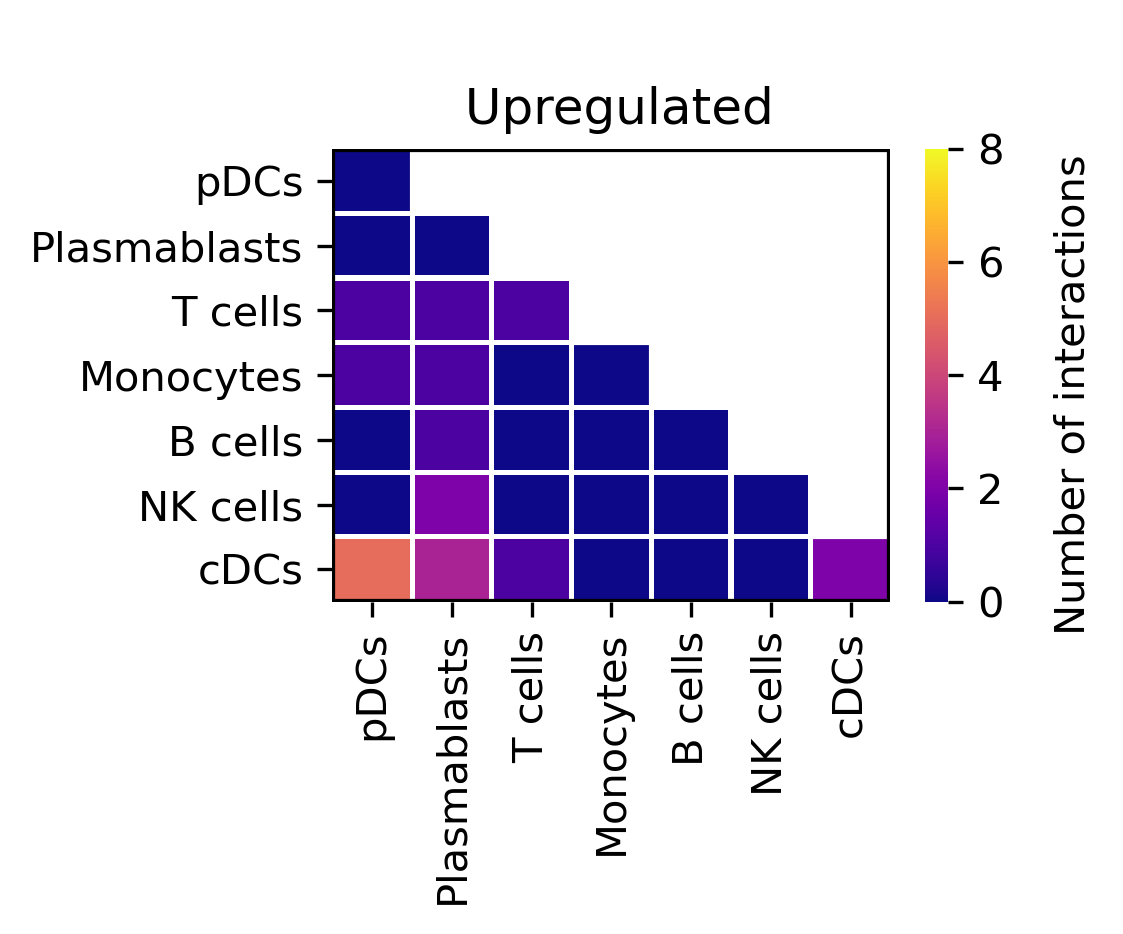

In [7]:
from make_figure_functions import inter_number
print('get heatmap showing the number of upregulated interactions')
inter_number(up_up, 8, 'Up')

get heatmap showing the number of downregulated interactions


{'figure': <Figure size 900x600 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'\n Downregulated'}>}

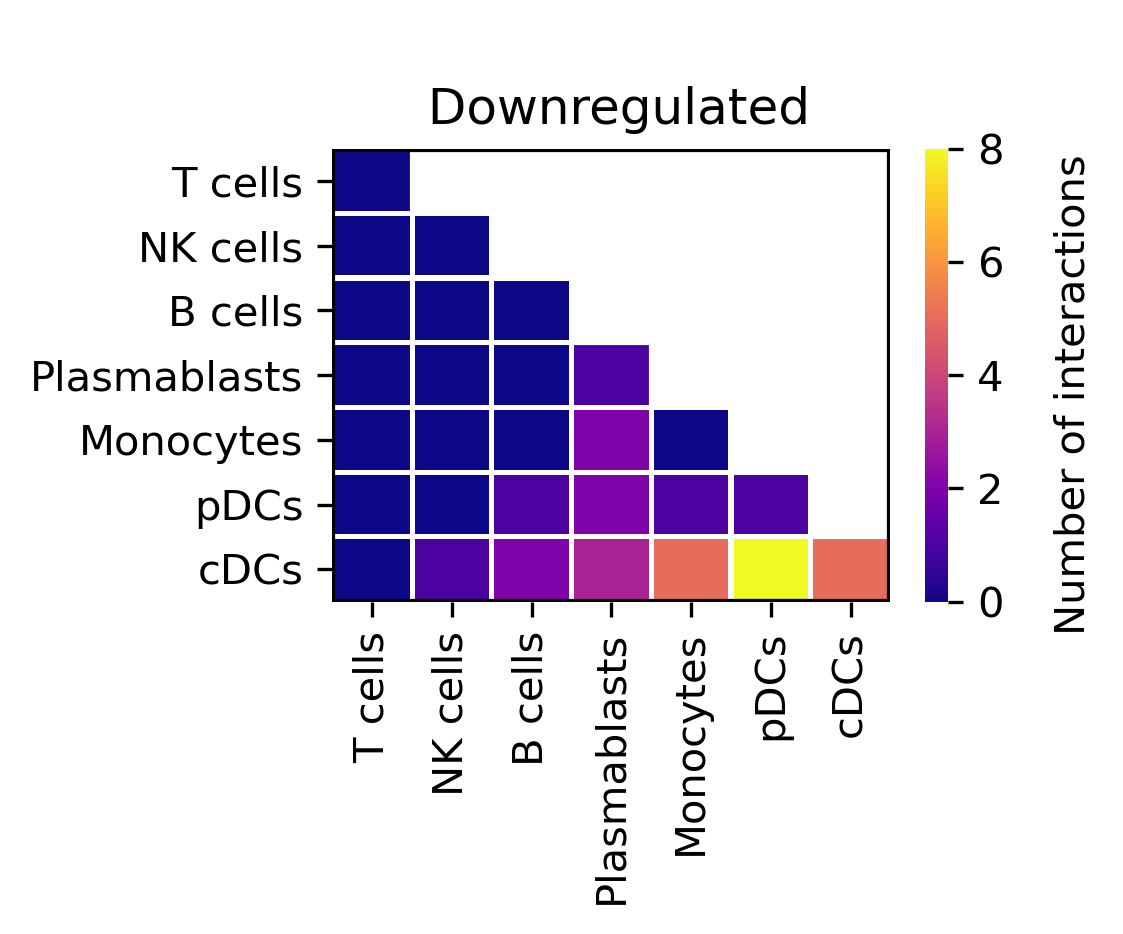

In [10]:
print('get heatmap showing the number of downregulated interactions')
inter_number(down_down, 8, 'Down')

get heatmap showing the number of mixregulated interactions


{'figure': <Figure size 900x600 with 2 Axes>,
 'ax': <AxesSubplot:title={'center':'Mixregulated'}>}

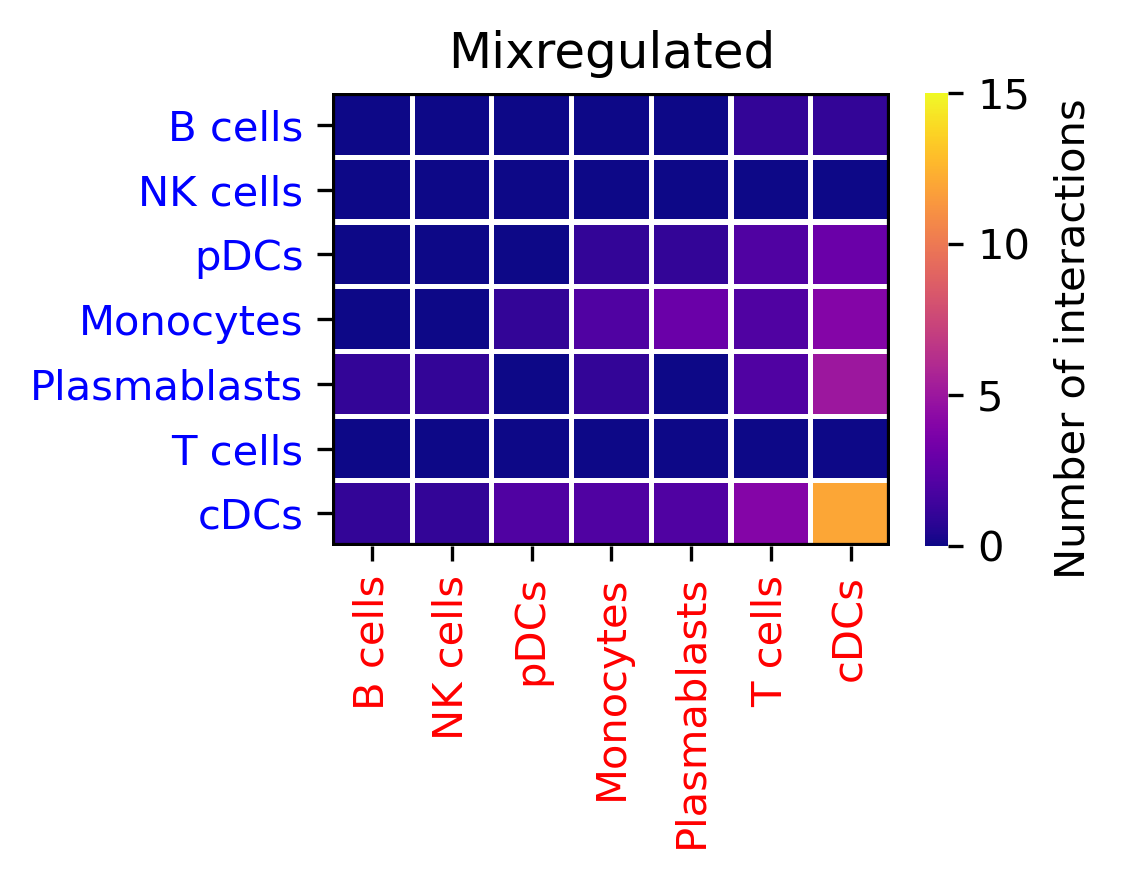

In [11]:
from make_figure_functions import inter_mix_number
print('get heatmap showing the number of mixregulated interactions')
inter_mix_number(up_down, 15)

In [5]:
up_up = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/upregulated_1_05_002.tsv')
down_down = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/downregulated_1_05_002.tsv')
up_down = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/mixregulated_1_05_002.tsv')

In [72]:
from my_mushroom import s_mushrooms

<ipython-input-152-2734b928c141>:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x2340 with 7 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

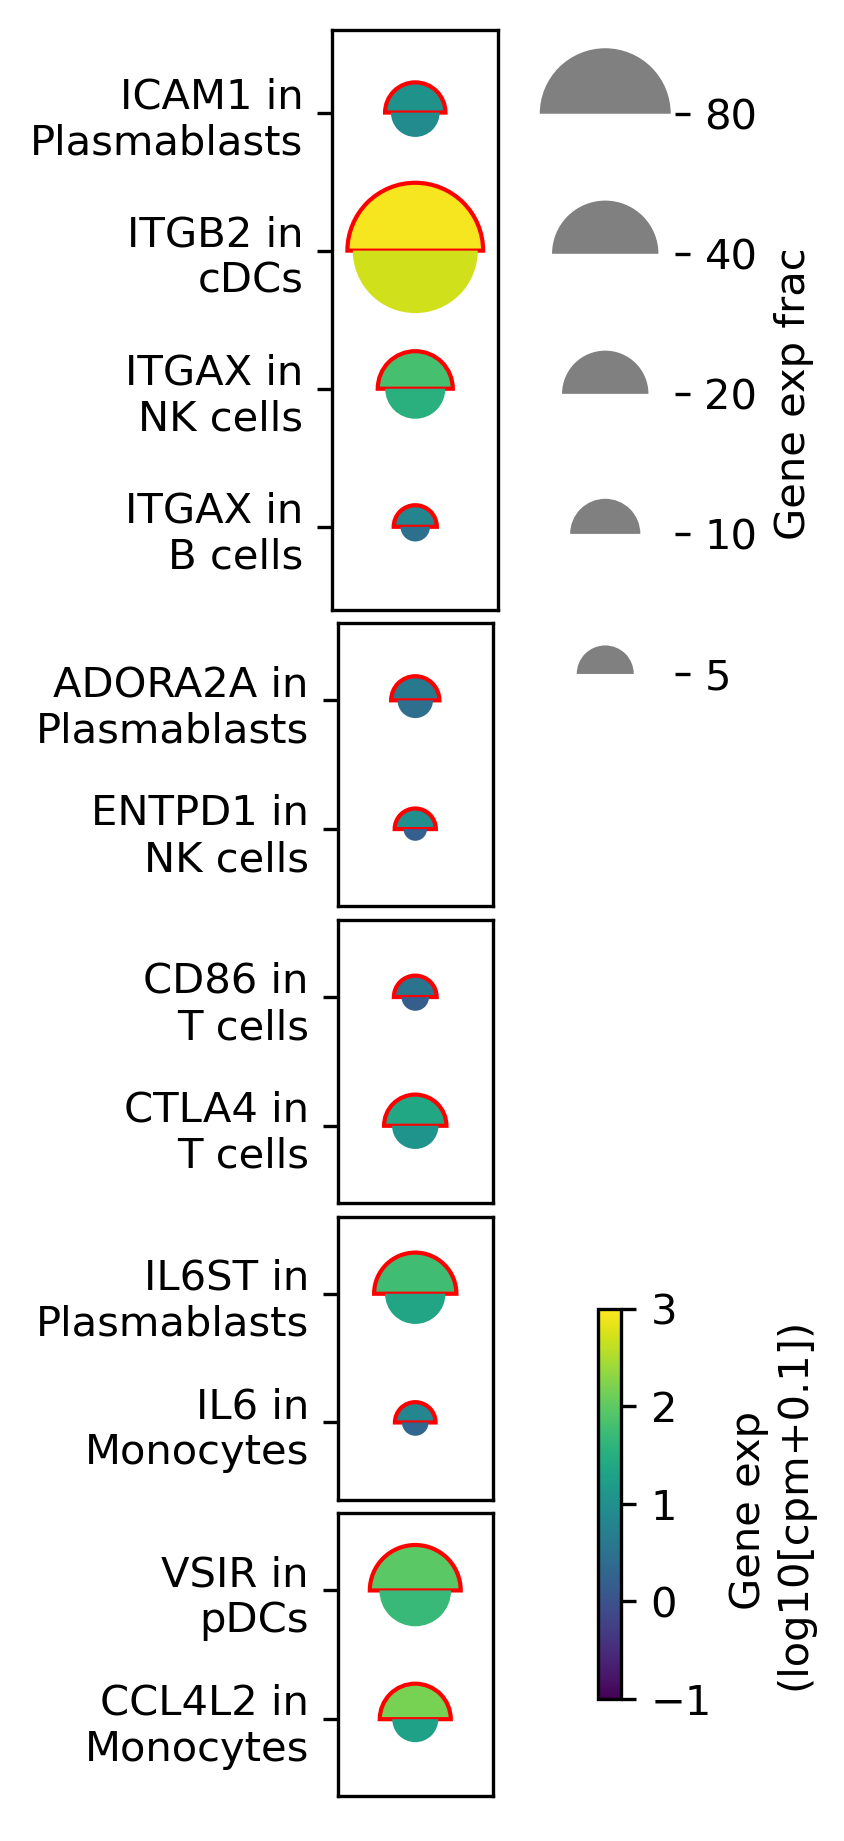

In [153]:
up_up_genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'ENTPD1': ['NK_cells'], 'ADORA2A': ['Plasmablasts']},
         {'CTLA4': ['T_cells'], 'CD86': ['T_cells']},
         {'IL6': ['Monocytes'], 'IL6ST': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]

s_mushrooms(up_up_genes)

<ipython-input-157-89d5003305c7>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x1260 with 5 Axes>,
 'ax': [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]}

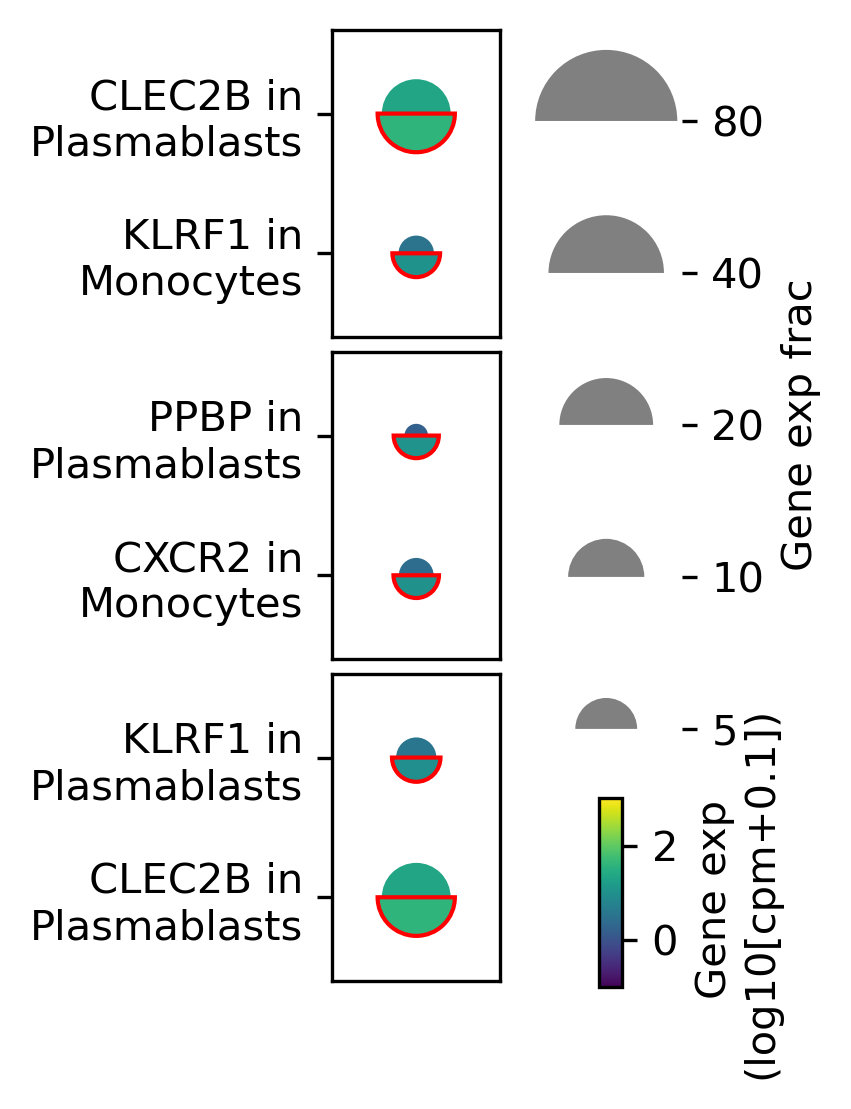

In [158]:
down_down_genes = [{'KLRF1': 'Monocytes', 'CLEC2B': 'Plasmablasts'},
 {'CXCR2': 'Monocytes', 'PPBP': 'Plasmablasts'},
 {'CLEC2B': 'Plasmablasts', 'KLRF1': 'Plasmablasts'}]

down_down_genes_new = []
for i, gene in enumerate(down_down_genes):
    down_down_genes_new.append({})
    for key in gene.keys():
        if isinstance(gene[key], list):
            down_down_genes_new[i][key] = gene[key]
        else:
            down_down_genes_new[i][key] = [gene[key]]

s_mushrooms(down_down_genes_new)

In [ ]:
def s_mushrooms(genes):
    '''
    genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]
    '''
    from matplotlib.patches import Wedge
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import math
    import numpy as np
    import pandas as pd
    import itertools

    conditions = ['S_dengue', 'dengue']
    cmap = plt.cm.get_cmap('viridis')
    vmin, vmax = -1, 3
    threshold = 0.1
    frac = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/fra.tsv', index_col=['cell_type', 'condition', 'gene'], squeeze=True)
    avg = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/exp.tsv', index_col=['cell_type', 'condition', 'gene'], squeeze=True)

    yl = sum([len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes])
    fig = plt.figure(figsize=((1 + 0.8 * 2) * 0.6, (1 + yl)* 0.6), dpi=300)

    grid = plt.GridSpec(yl , 2, wspace=0.1, hspace=0.1)

    axs = []
    for i in range(len(genes)):
         axs.append(plt.subplot(grid[sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i]): sum(len(list(itertools.chain.from_iterable(genesi.values()))) for genesi in genes[: i+1]), 0: 1]))
    size_bar = plt.subplot(grid[0: 5, 1: 2])

    datap = []
    for genesi, ax in zip(genes, axs):
        cts = list(genesi.values())
        gs = list(genesi.keys())
        yticklabels = []
        for i, (csts, gene) in enumerate(zip(cts, gs)):
            avgs = []
            for cst in csts:
                yticklabels.append(gene + ' in\n' + cst.replace('_', ' '))
                for k, cond in enumerate(conditions):
                    fr = frac.loc[(cst, cond, gene)]
                    av = np.log10(avg.loc[(cst, cond, gene)] + 0.1)
                    avgs.append(av)

                    r = 0.5 * fr**0.3
                    color = cmap((min(vmax, av) - vmin) / (vmax - vmin))
                    theta0, theta1 = 180 * (k > 0), 180 + 180 * (k > 0)
                    datap.append({
                        'r': r,
                        'facecolor': color,
                        'center': (0, len(yticklabels)-1),
                        'theta': (theta0, theta1),
                        'ax': ax,
                    })
                if avgs[0] - avgs[1] > threshold:
                    datap[-2]['edgecolor'] = 'red'
                    datap[-1]['edgecolor'] = 'none'
                elif avgs[0] - avgs[1] < -threshold:
                    datap[-1]['edgecolor'] = 'red'
                    datap[-2]['edgecolor'] = 'none'
                else:
                    datap[-1]['edgecolor'] = 'none'
                    datap[-2]['edgecolor'] = 'none'   


        ax.set_yticks(np.arange(len(list(itertools.chain.from_iterable(genesi.values())))))
        ax.set_yticklabels(yticklabels)
        ax.set_ylim(-0.6, len(list(itertools.chain.from_iterable(genesi.values()))) - 0.4)        
        ax.set_xticks([])
        ax.set_xlim(-0.6, 1 - 0.4)

    for datum in datap:
        ax = datum['ax']
        r = datum['r']
        color = datum['facecolor']
        center = datum['center']
        theta0, theta1 = datum['theta']
        ec = datum['edgecolor']

        h = Wedge(
            center, r, theta0, theta1, facecolor=color, edgecolor=ec
        )
        ax.add_artist(h)
        ax.set_aspect(1)

    size_bar.set_ylim(-0.6, 5 - 0.4)        
    c = [(0.5, i) for i in range(5)]
    radius = [0.5 * fr**0.3 for fr in [0.05, 0.1, 0.2, 0.4, 0.8]]
    for c, r in zip(c, radius):
        e = Wedge(c, r, 0, 180, facecolor='gray',)
        size_bar.add_artist(e)
    size_bar.set_aspect(1)
    size_bar.set_yticks([])
    size_bar.set_yticks(range(5))
    size_bar.set_yticklabels(['5', '10', '20', '40', '80'])
    size_bar.yaxis.tick_right()
    size_bar.yaxis.set_label_position('right')
    size_bar.set_ylabel('Gene exp frac')
    size_bar.set_xticks([])
    size_bar.spines['bottom'].set_visible(False)
    size_bar.spines['top'].set_visible(False)
    size_bar.spines['right'].set_visible(False)
    size_bar.spines['left'].set_visible(False)

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax) 
    cmap = plt.cm.get_cmap('viridis')
    position = fig.add_axes([0.7, 0.02*yl, 0.05, 2/yl])
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=position, ax=axs[-1], label='Gene exp \n(log10[cpm+0.1])')

    fig.tight_layout()
    return {'fig': fig, 'ax': axs}

<ipython-input-171-db9244a4cb2e>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x5040 with 13 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

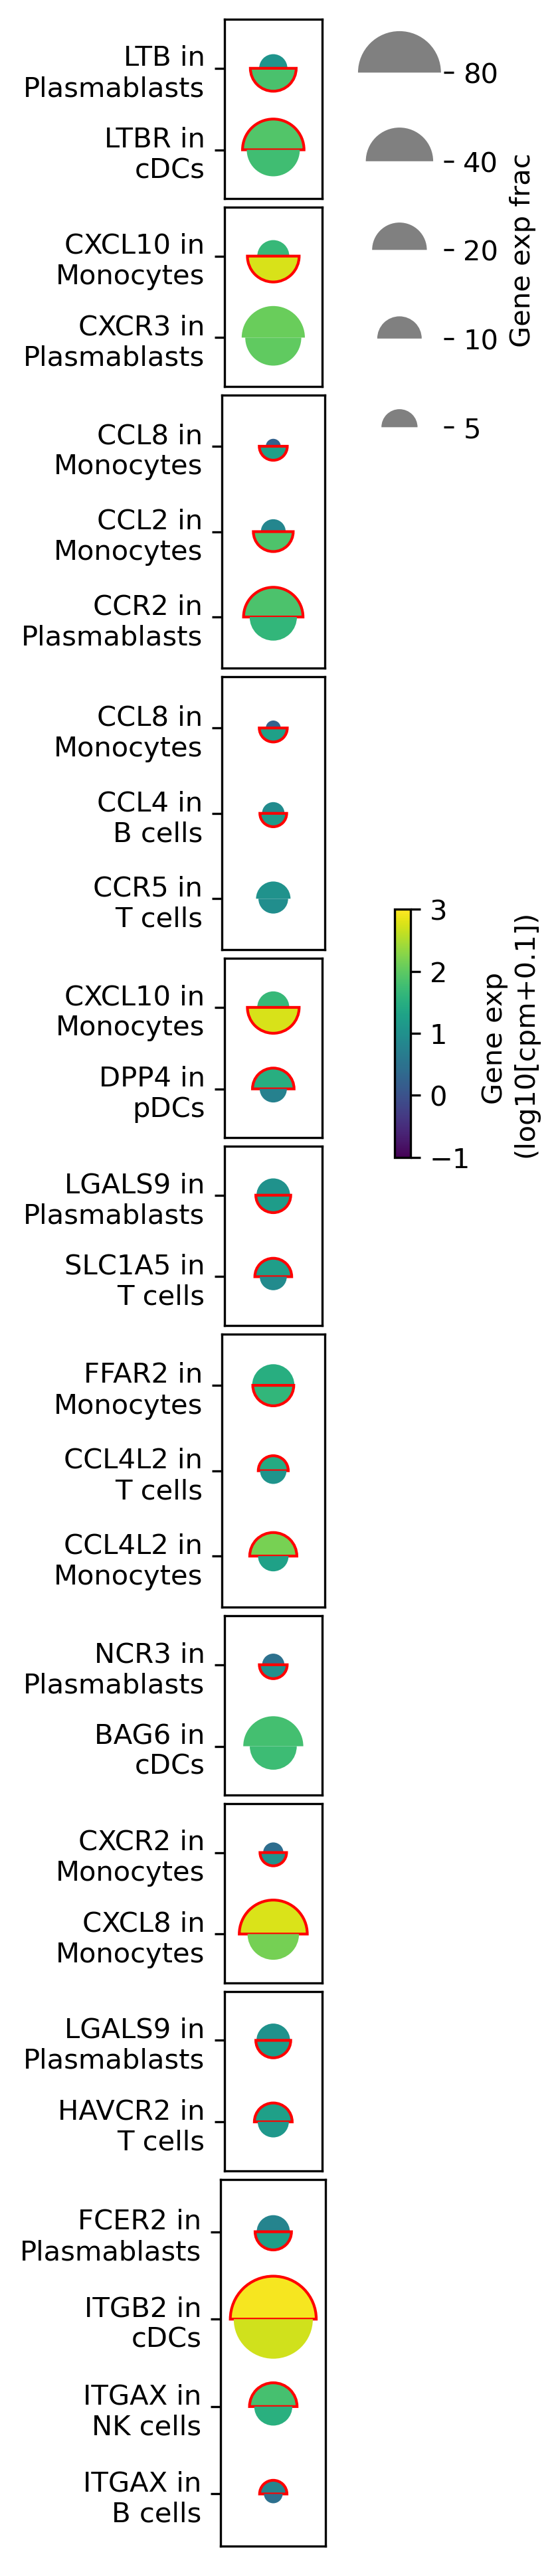

In [172]:
up_down_genes = [{'LTBR': 'cDCs', 'LTB': 'Plasmablasts'},
                 {'CXCR3': 'Plasmablasts', 'CXCL10': 'Monocytes'},
                 {'CCR2': 'Plasmablasts', 'CCL2': 'Monocytes', 'CCL8': 'Monocytes'},
                 {'CCR5': 'T_cells', 'CCL4': 'B_cells', 'CCL8': 'Monocytes'},
                 #{'RETN': 'Monocytes', 'GPR25': 'Plasmablasts'},
                 {'DPP4': 'pDCs', 'CXCL10': 'Monocytes'},
                 {'SLC1A5': 'T_cells', 'LGALS9': 'Plasmablasts'},
                 {'CCL4L2': ['Monocytes', 'T_cells'], 'FFAR2': 'Monocytes'},
                 #{'CCL4L2': 'T_cells', 'FFAR2': 'Monocytes'},
                 {'BAG6': 'cDCs', 'NCR3': 'Plasmablasts'},
                 {'CXCL8': 'Monocytes', 'CXCR2': 'Monocytes'},
                 #{'CCR2': 'Plasmablasts', 'CCL8': 'Monocytes'},
                 #{'CCR5': 'T_cells', 'CCL8': 'Monocytes'},
                 {'HAVCR2': 'T_cells', 'LGALS9': 'Plasmablasts'},
                 {'ITGAX': ['B_cells', 'NK_cells'], 'ITGB2': 'cDCs', 'FCER2': 'Plasmablasts'},
                 #{'ITGAX': 'NK_cells', 'FCER2': 'Plasmablasts'},
                 #{'ITGB2': 'cDCs', 'FCER2': 'Plasmablasts'}
                ]

up_down_genes_new = []
for i, gene in enumerate(up_down_genes):
    up_down_genes_new.append({})
    for key in gene.keys():
        if isinstance(gene[key], list):
            up_down_genes_new[i][key] = gene[key]
        else:
            up_down_genes_new[i][key] = [gene[key]]

s_mushrooms(up_down_genes_new)

In [175]:
down_down_genes_new

[{'KLRF1': ['Monocytes'], 'CLEC2B': ['Plasmablasts']},
 {'CXCR2': ['Monocytes'], 'PPBP': ['Plasmablasts']},
 {'CLEC2B': ['Plasmablasts'], 'KLRF1': ['Plasmablasts']}]

<ipython-input-171-db9244a4cb2e>:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


{'fig': <Figure size 468x8100 with 20 Axes>,
 'ax': [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>]}

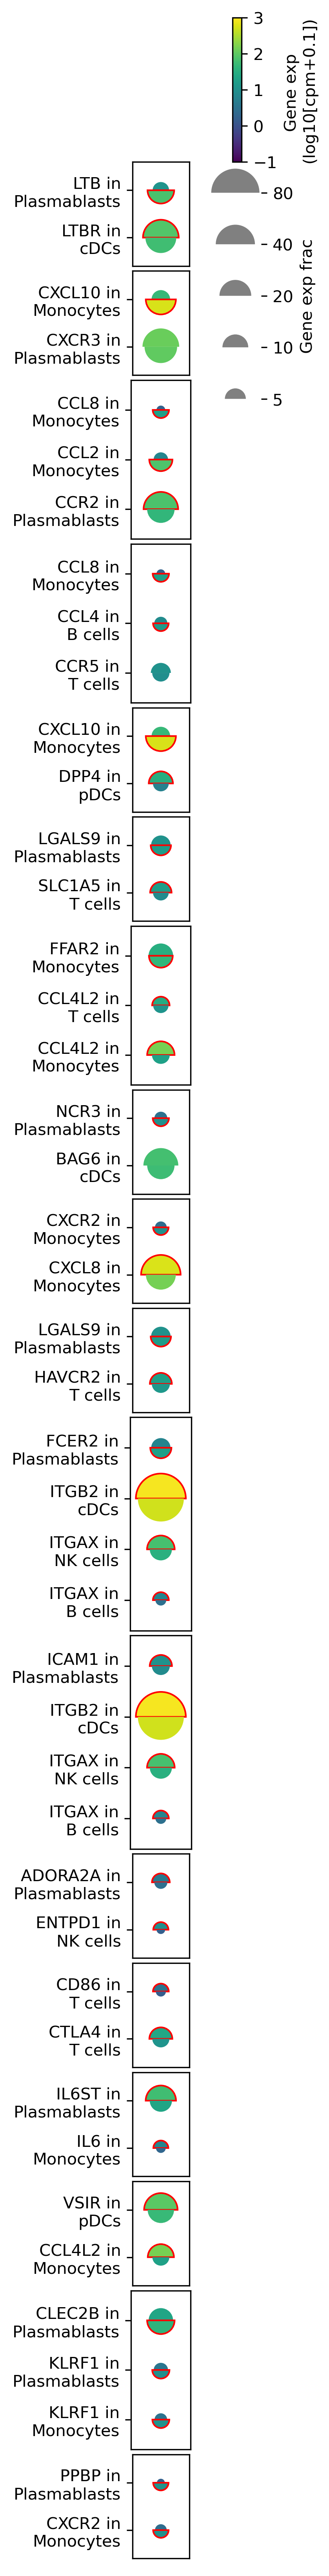

In [176]:
up_up_genes = [{'ITGAX': ['B_cells', 'NK_cells'],
          'ITGB2': ['cDCs'],
          'ICAM1': ['Plasmablasts']},
         {'ENTPD1': ['NK_cells'], 'ADORA2A': ['Plasmablasts']},
         {'CTLA4': ['T_cells'], 'CD86': ['T_cells']},
         {'IL6': ['Monocytes'], 'IL6ST': ['Plasmablasts']},
         {'CCL4L2': ['Monocytes'], 'VSIR': ['pDCs']}]

down_down_genes_new = [{'KLRF1': ['Monocytes', 'Plasmablasts'], 'CLEC2B': ['Plasmablasts']},
 {'CXCR2': ['Monocytes'], 'PPBP': ['Plasmablasts']},]

s_mushrooms(up_down_genes_new + up_up_genes + down_down_genes_new)

In [50]:
def randomization(genes):
    log2fc = defaultdict(list)
    r = defaultdict(list)
    pvalue = {}
    
    for inter in genes:
        ga = list(inter.keys())[0]
        cta = inter[ga]
        gb = list(inter.keys())[1]
        ctb = inter[gb]
        
        adata_g = {}
        adata_children = adata[adata.obs['dataset'] == 'child']
        for gene, ct in zip([ga, gb], [cta, ctb]):
            if ct == 'cDCs':
                adata_children = adata_children[~adata_children.obs['ID'].isin(['1_140_01', '5_193_01'])]
                
            adata_g[gene] = adata_children[adata_children.obs['cell_type'] == ct][:, gene]   
        avg = {(gene, cd): adata_g[gene][adata_g[gene].obs['Condition'] == cd].X.toarray().mean() for gene in [ga, gb] for cd in ['S_dengue', 'dengue']}
        lfc = {gene: np.log2(avg[gene, 'S_dengue'] + 0.1) - np.log2(avg[gene, 'dengue'] + 0.1) for gene in [ga, gb]}
        log2fc[(ga, cta, gb, ctb)].append([lfc[ga], lfc[gb]])
        r0 = (float(lfc[ga])**2 + float(lfc[gb])**2)**0.5
        r[(ga, cta, gb, ctb)].append(r0)
        
        p = 0
        for i in range(1000):
            adata_i = adata_g
            raw = {gene: adata_i[gene].obs['Condition'].tolist() for gene in [ga, gb]}
            for gene in [ga, gb]:
                random.shuffle(raw[gene])
                adata_i[gene].obs['Condition'] = raw[gene]
            avg_i = {(gene, cd): adata_i[gene][adata_i[gene].obs['Condition'] == cd].X.toarray().mean() for gene in [ga, gb] for cd in ['S_dengue', 'dengue']}
            log2fc_i = {gene: np.log2(avg_i[gene, 'S_dengue'] + 0.1) - np.log2(avg_i[gene, 'dengue'] + 0.1) for gene in [ga, gb]}
            log2fc[(ga, cta, gb, ctb)].append([log2fc_i[ga], log2fc_i[gb]])
            ri = (float(log2fc_i[ga])**2 + float(log2fc_i[gb])**2)**0.5
            r[(ga, cta, gb, ctb)].append(ri)
            if ri >= r0:
                p += 1
        pvalue[(ga, cta, gb, ctb)] = p * 0.001

    res = pd.DataFrame([])
    for key in log2fc.keys():
        log2fc[key] = pd.DataFrame(log2fc[key], columns = ['log2fc_ga', 'log2fc_gb'])
        log2fc[key]['r'] = r[key]
        log2fc[key]['pvalue'] = pvalue[key]
        for i, s in enumerate(['ga', 'cta', 'gb', 'ctb']):
            log2fc[key][s] = key[i]
        res = pd.concat([res, log2fc[key]])
    res = res.set_index(['ga', 'cta', 'gb', 'ctb'])
        
    return res

In [65]:
genes = [{ga: cta, gb : ctb} for ga, cta, gb, ctb in zip(down_down['ga'].tolist(), down_down['cta'].tolist(), down_down['gb'].tolist(), down_down['ctb'].tolist())]
res = randomization(genes)
res.to_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/randomization_down_down.tsv')

######################################################################
fdn = '/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/randomization/up_up/'
for inter in genes:
    fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
    ga = list(inter.keys())[0]
    cta = inter[ga]
    gb = list(inter.keys())[1]
    ctb = inter[gb]
    
    log2fc = res.loc[ga, cta, gb, ctb]
    
    x0 = log2fc['log2fc_ga'].tolist()[0]
    y0 = log2fc['log2fc_gb'].tolist()[0]    

    x = log2fc['log2fc_ga'].tolist()[1:]
    y = log2fc['log2fc_gb'].tolist()[1:]

    ax.scatter(x0, y0, c='r', s=10)
    ax.scatter(x, y, c='blue', s=2)
    ax.axvline(0, c='gray', zorder=-3, lw=0.5)
    ax.axhline(0, c='gray', zorder=-3, lw=0.5)
    ax.set_ylim(-4, 4)
    ax.set_xlim(-4, 4)
    ax.set_xlabel('Log2fc of ' + ga + ' in ' + cta.replace('_', ' '))
    ax.set_ylabel('Log2fc of ' + gb + ' in ' + ctb.replace('_', ' '))
    ax.set_title('p value: ' + str(res.loc[ga, cta, gb, ctb]['pvalue'][0]))
    plt.savefig(fdn + ga + '_in_' + cta + '&' + gb + '_in_' + ctb + '.png', bbox_inches = 'tight')
#######################################################################
mushroom_genes = []
for inter in genes:
    ga = list(inter.keys())[0]
    cta = inter[ga]
    gb = list(inter.keys())[1]
    ctb = inter[gb]
    
    if res.loc[ga, cta, gb, ctb]['pvalue'][0] == 0:
        mushroom_genes.append({ga: cta, gb: ctb})       
mushroom_genes

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attrib

log2fc_ga  log2fc_gb         r  pvalue
ga    cta       gb     ctb                                                 
KLRF1 Monocytes CLEC2B Plasmablasts  -1.711326  -0.827141  1.900737   0.000
                       Plasmablasts  -0.108044   0.105510  0.151016   0.000
                       Plasmablasts  -0.631995  -0.075248  0.636459   0.000
                       Plasmablasts  -0.122356  -0.026746  0.125245   0.000
                       Plasmablasts   0.012661   0.035788  0.037962   0.000
...                                        ...        ...       ...     ...
CCL4  pDCs      CCR5   pDCs          -0.915956   1.594784  1.839107   0.013
                       pDCs          -0.584752   1.285373  1.412133   0.013
                       pDCs           1.836201   1.905728  2.646401   0.013
                       pDCs          -0.677712   0.873649  1.105693   0.013
                       pDCs           0.800701  -1.985093  2.140495   0.013

[32032 rows x 4 columns]

<ipython-input-179-3e36eac63575>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  log2fc = res.loc[ga, cta, gb, ctb]
<ipython-input-179-3e36eac63575>:29: PerformanceWarning: indexing past lexsort depth may impact performance.
  p = res.loc[ga, cta, gb, ctb]['pvalue'][0]


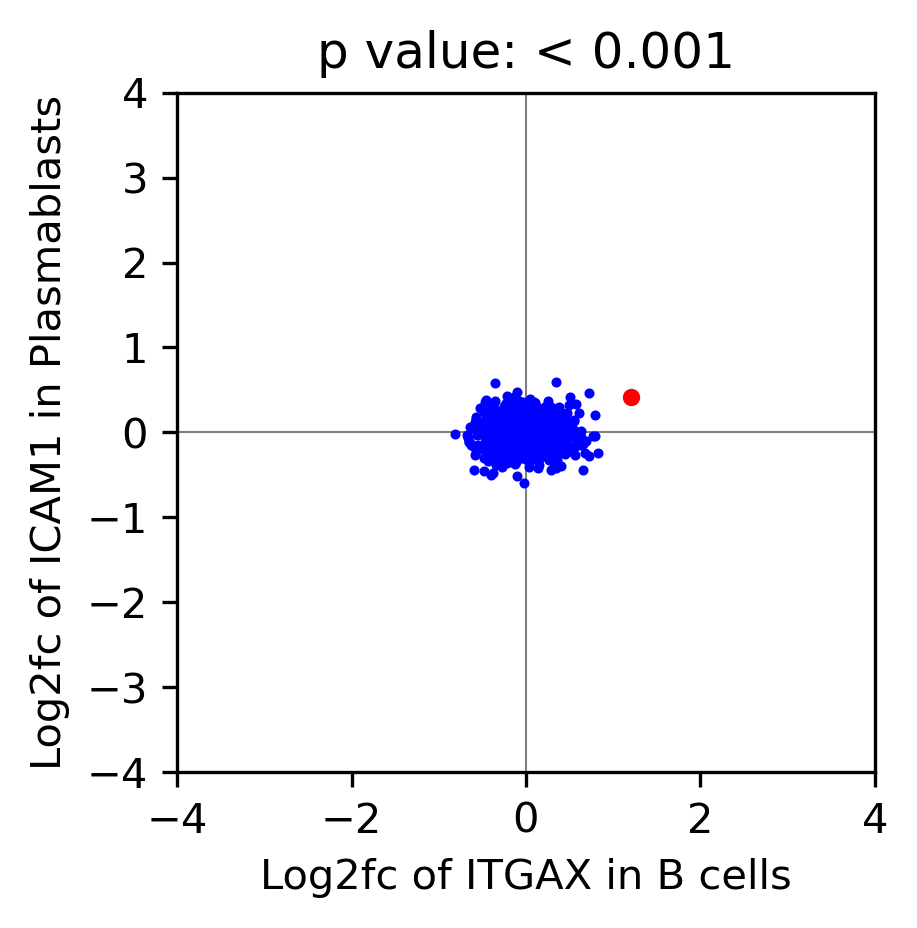

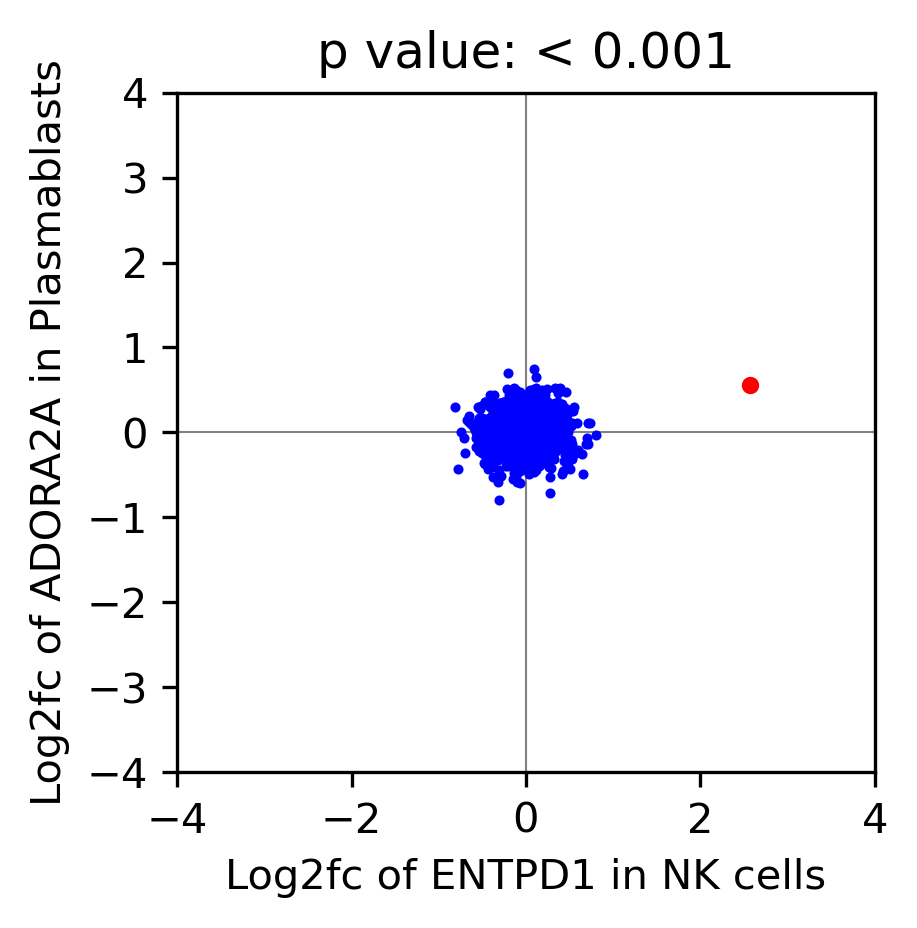

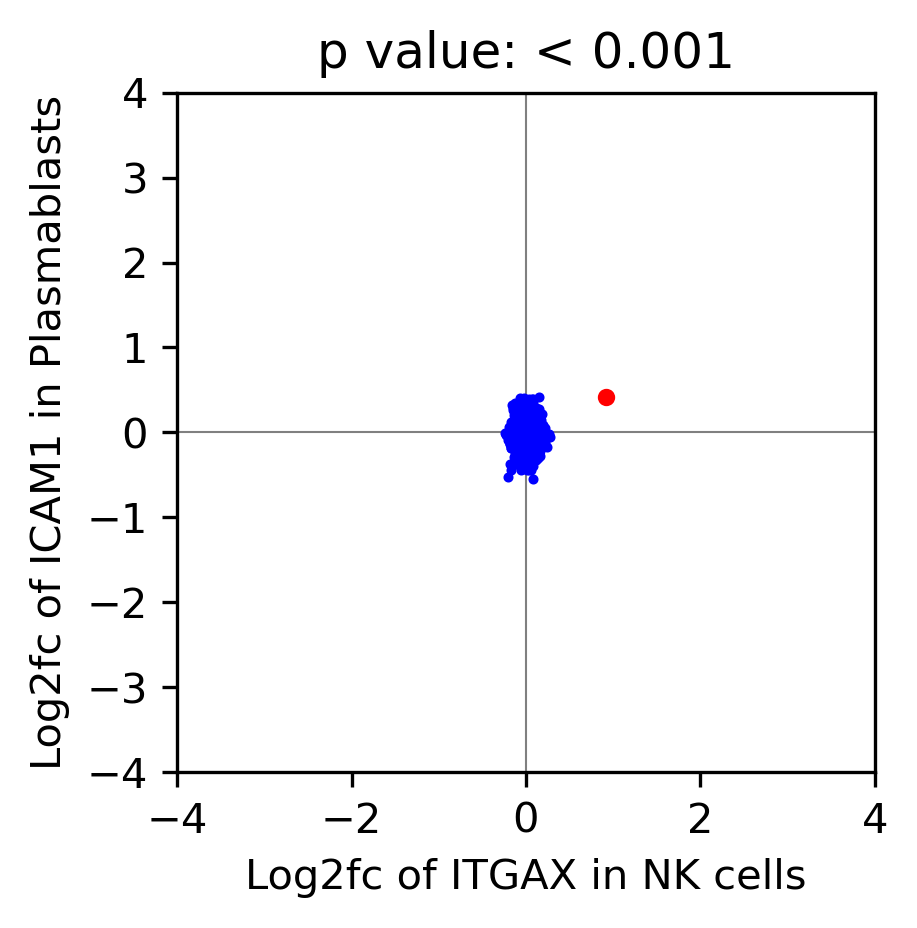

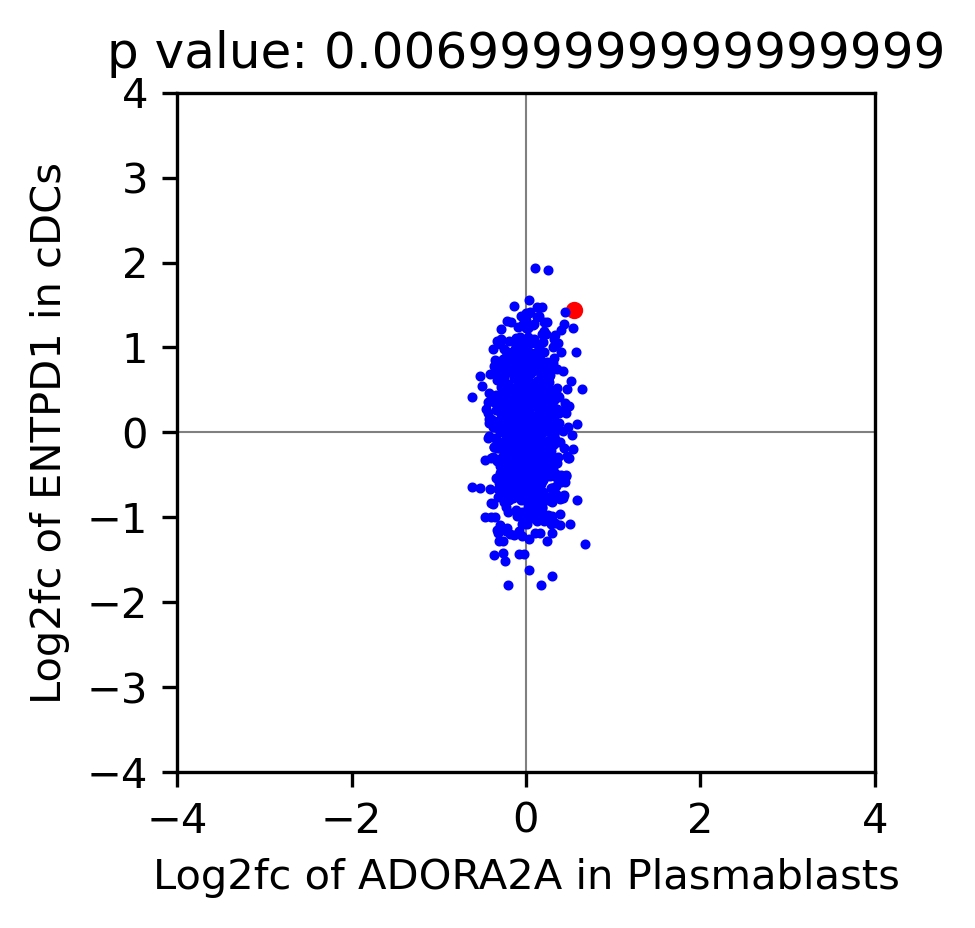

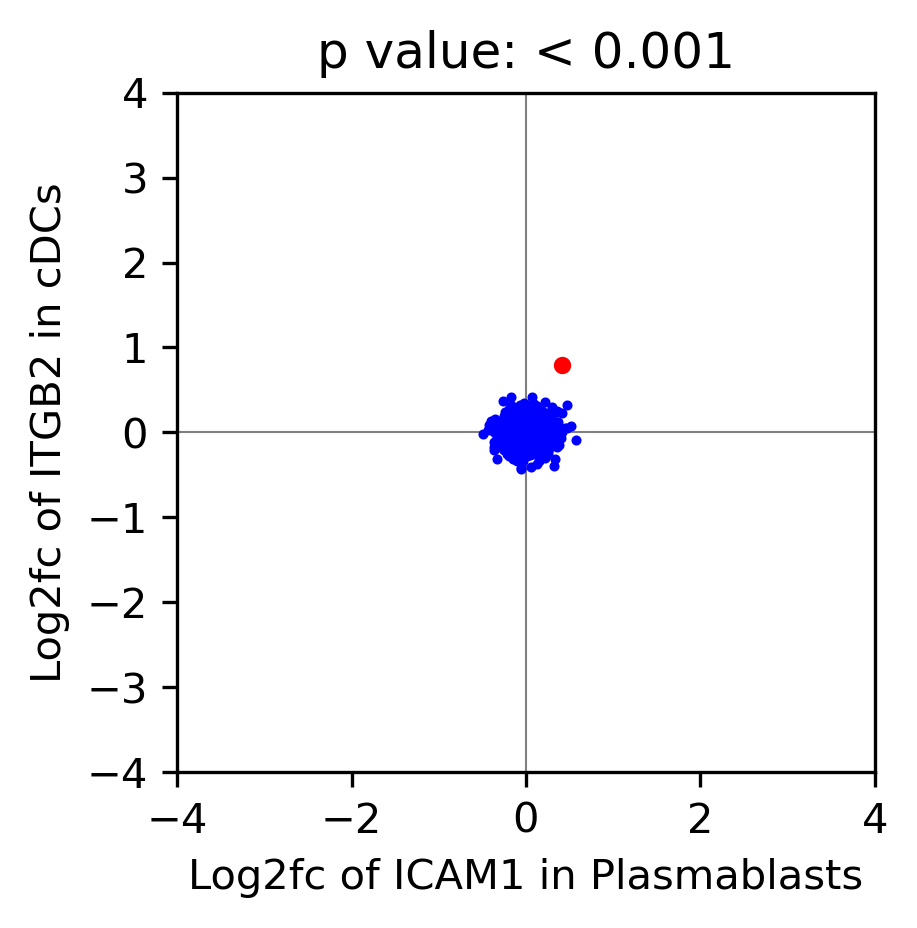

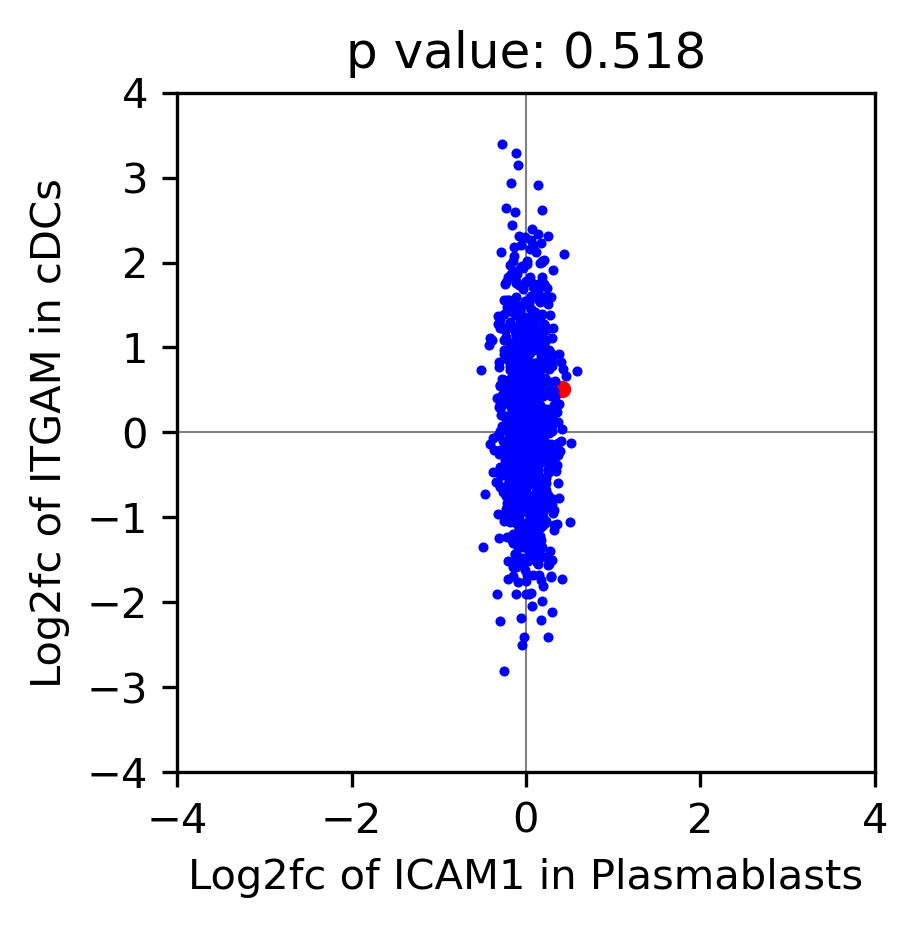

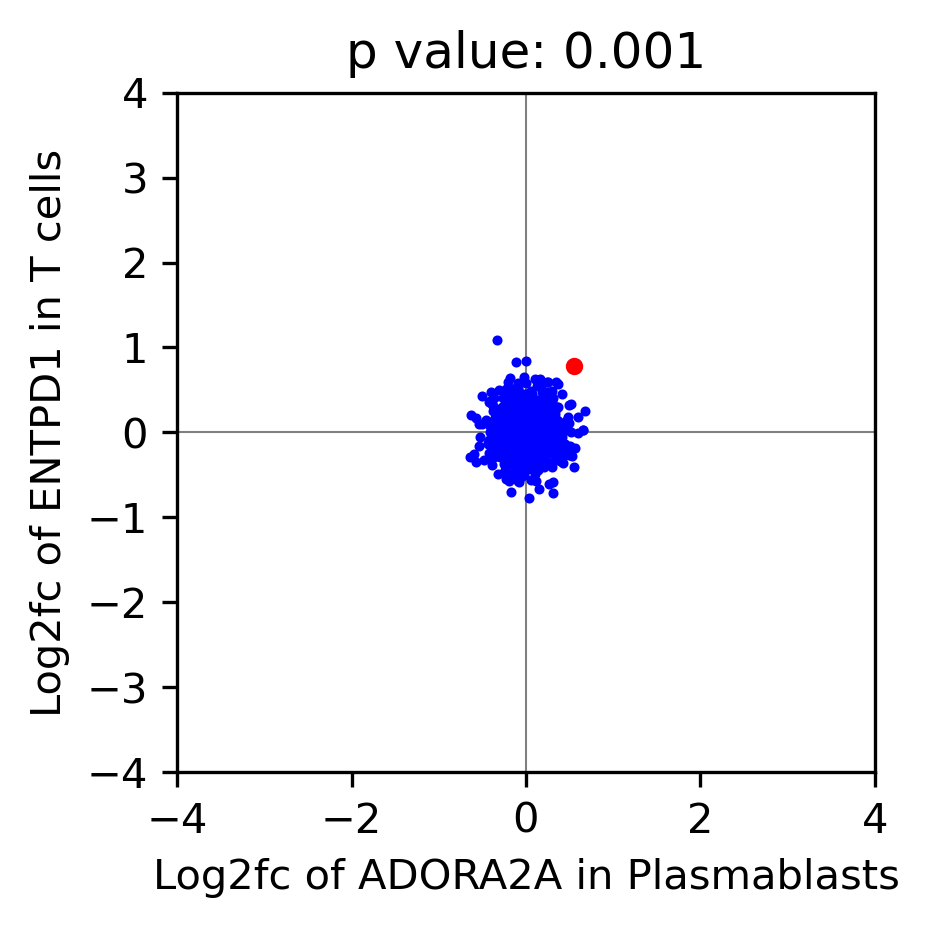

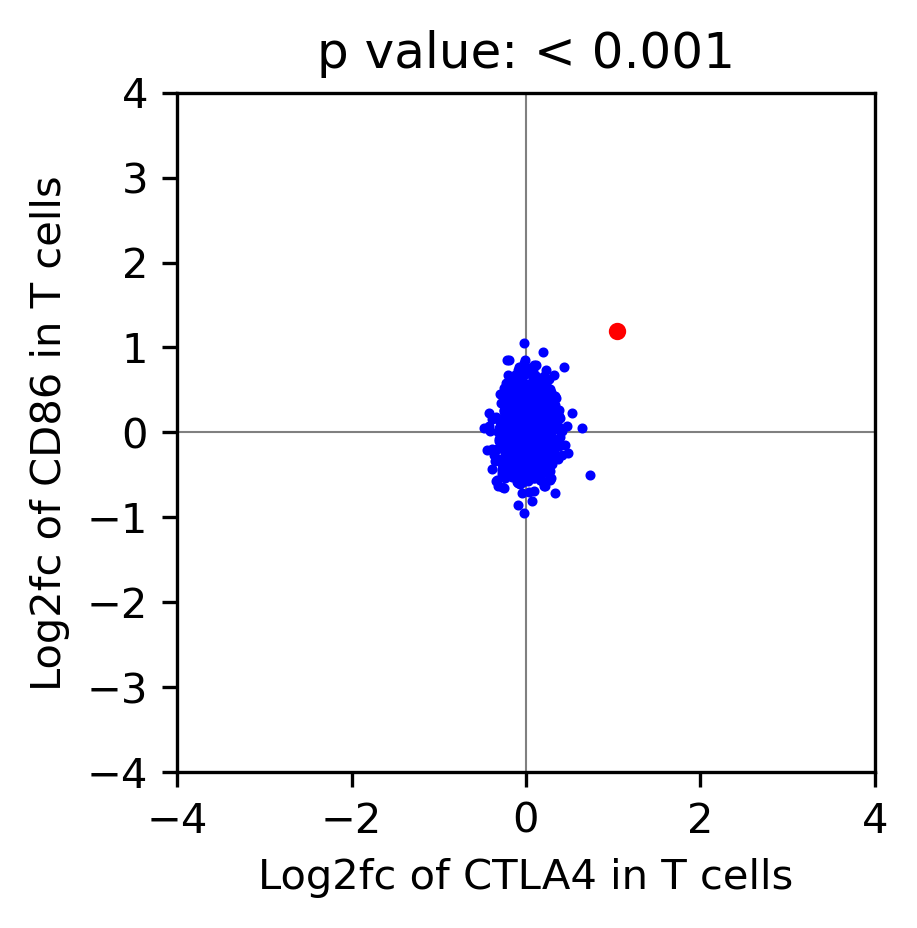

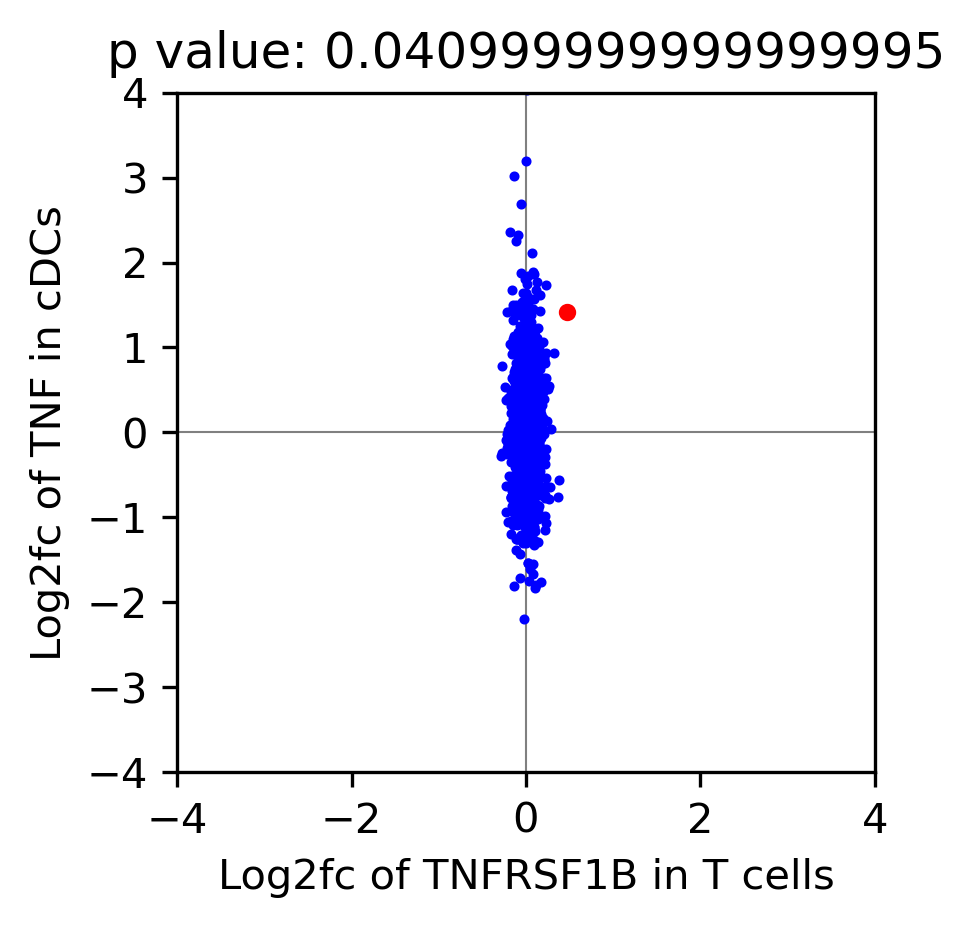

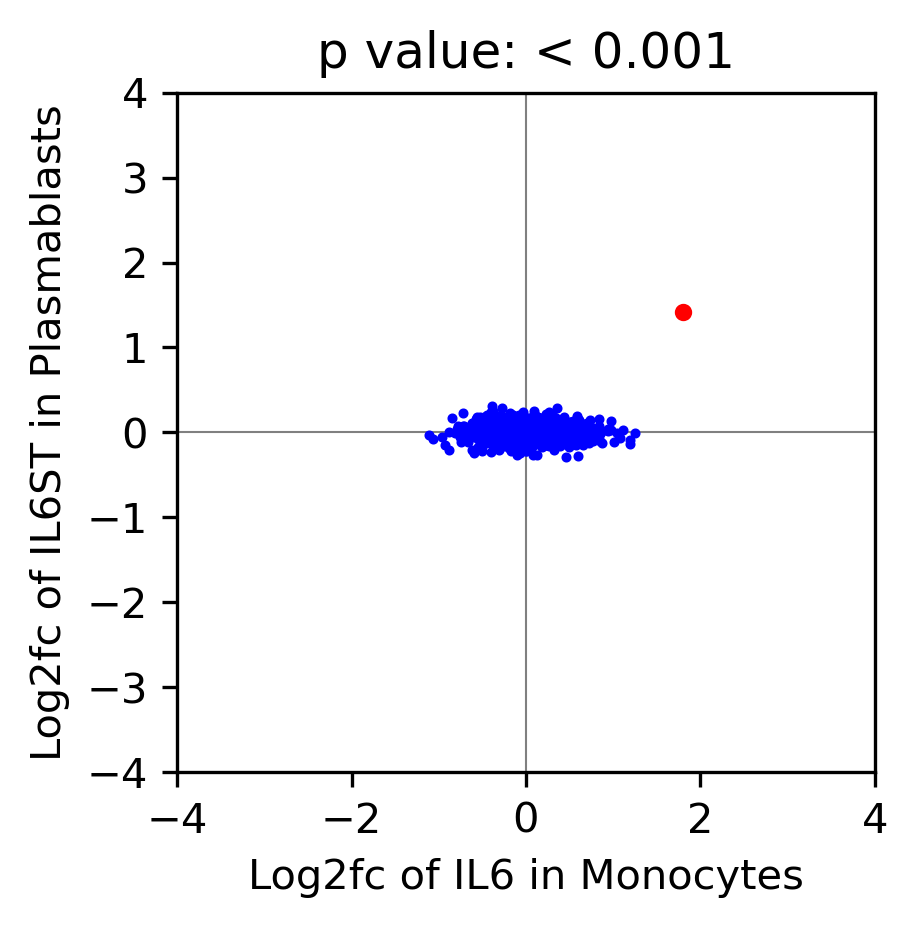

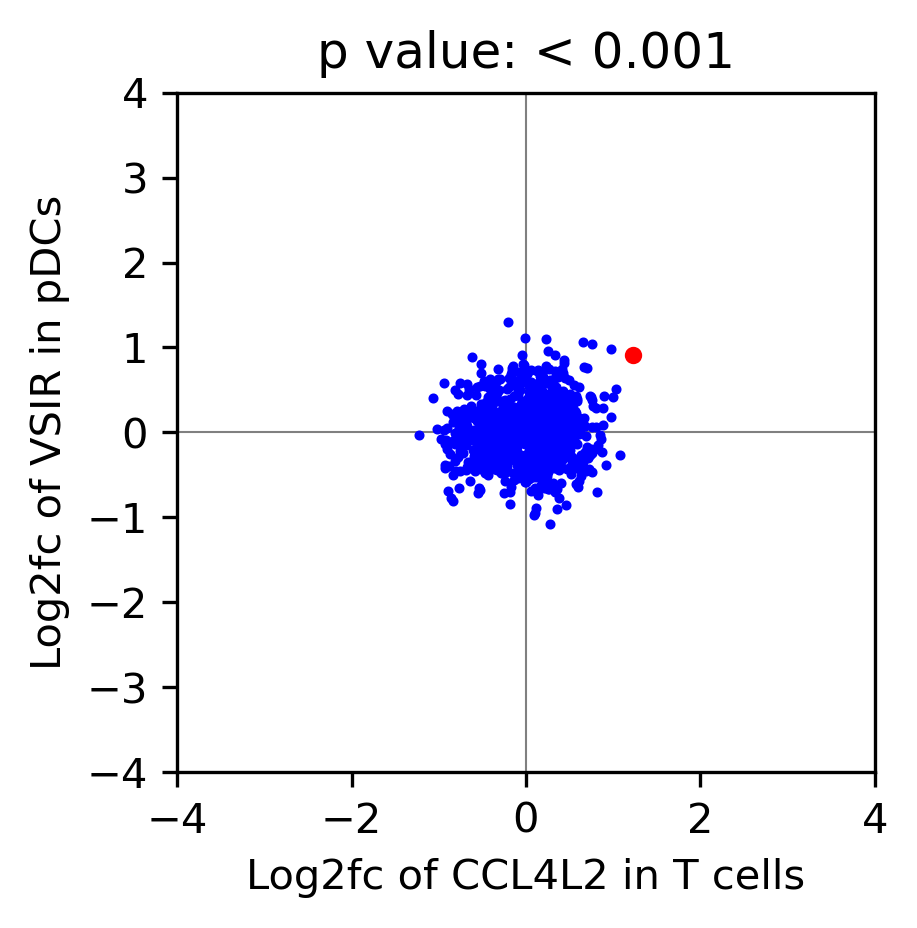

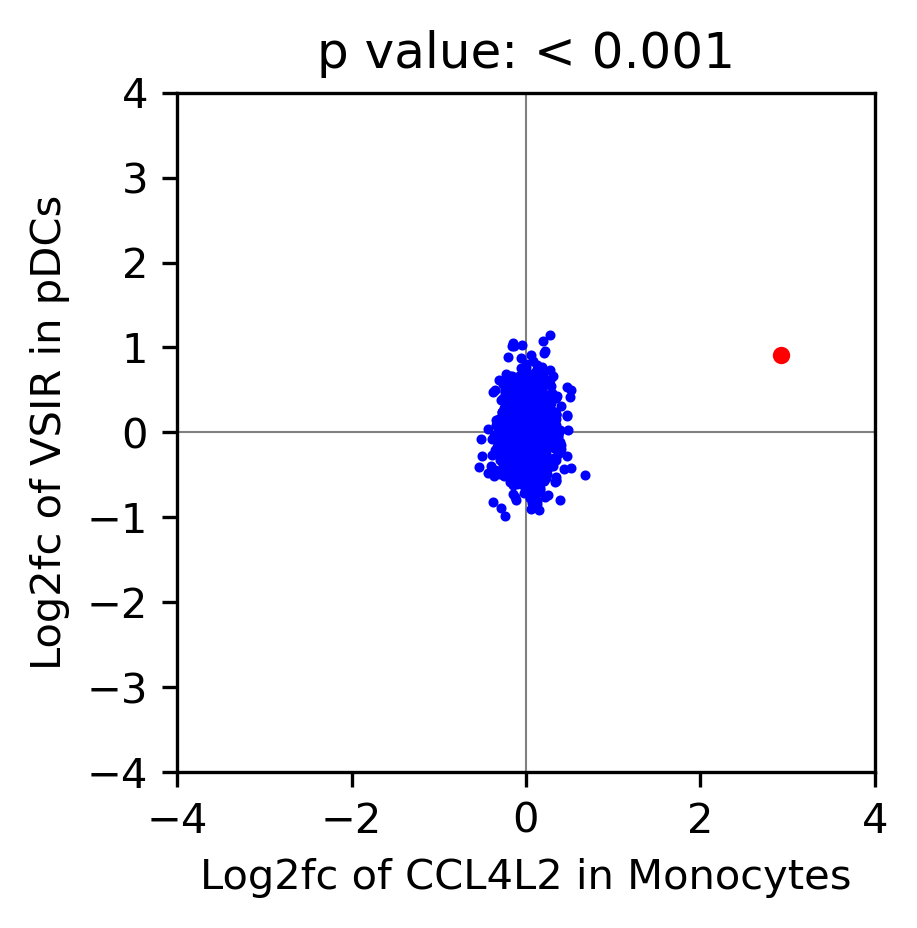

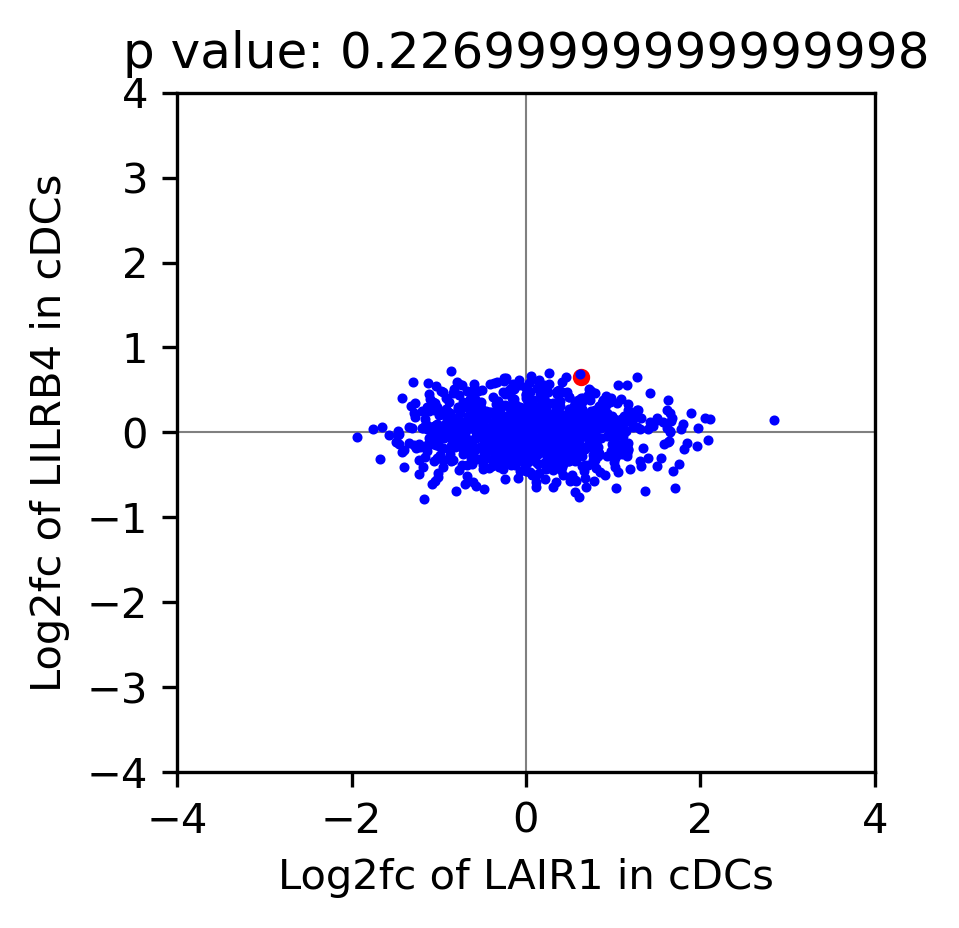

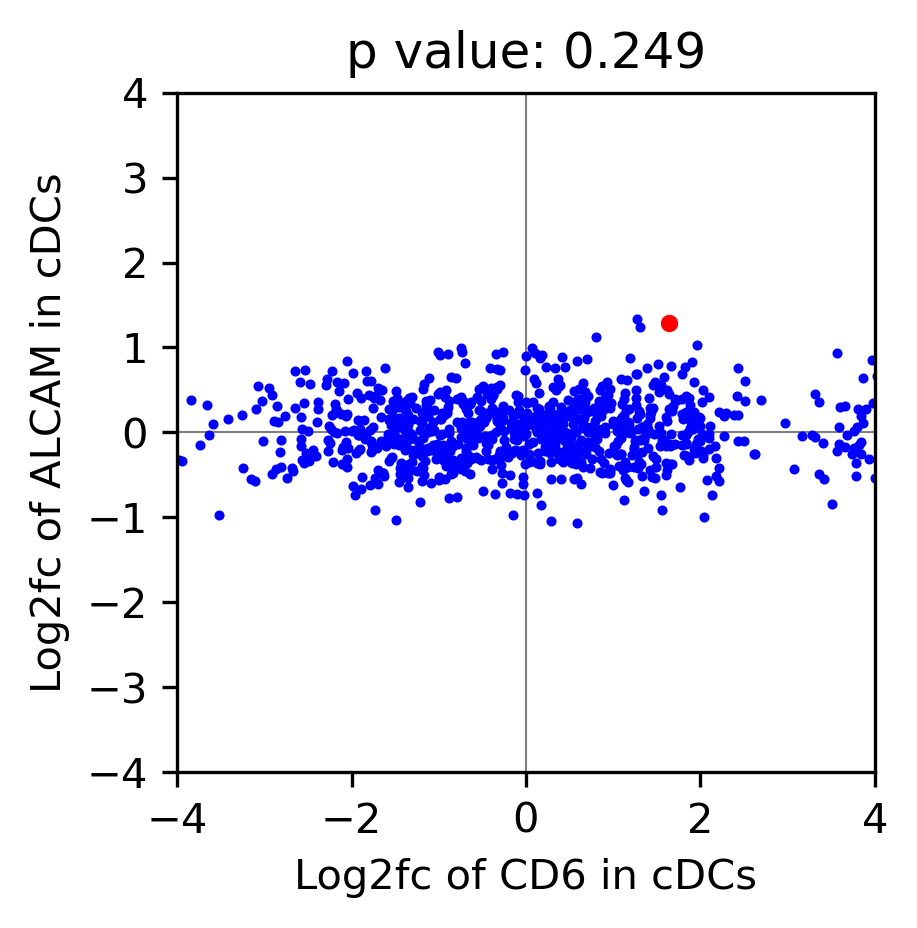

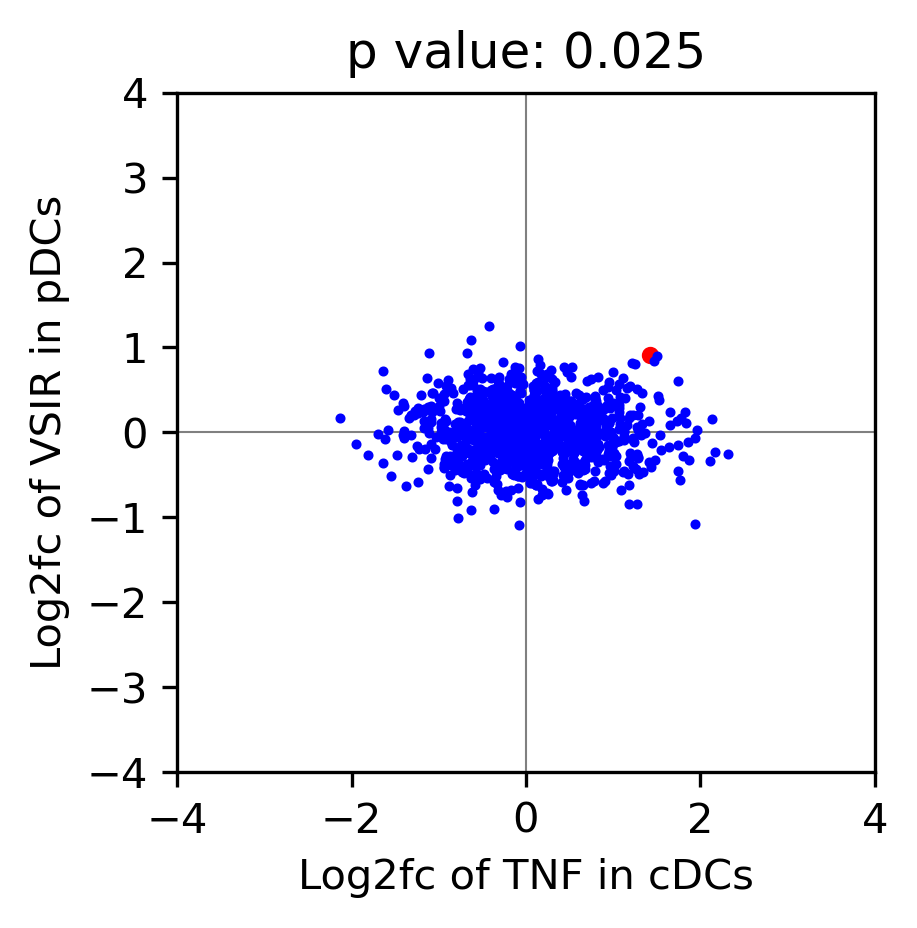

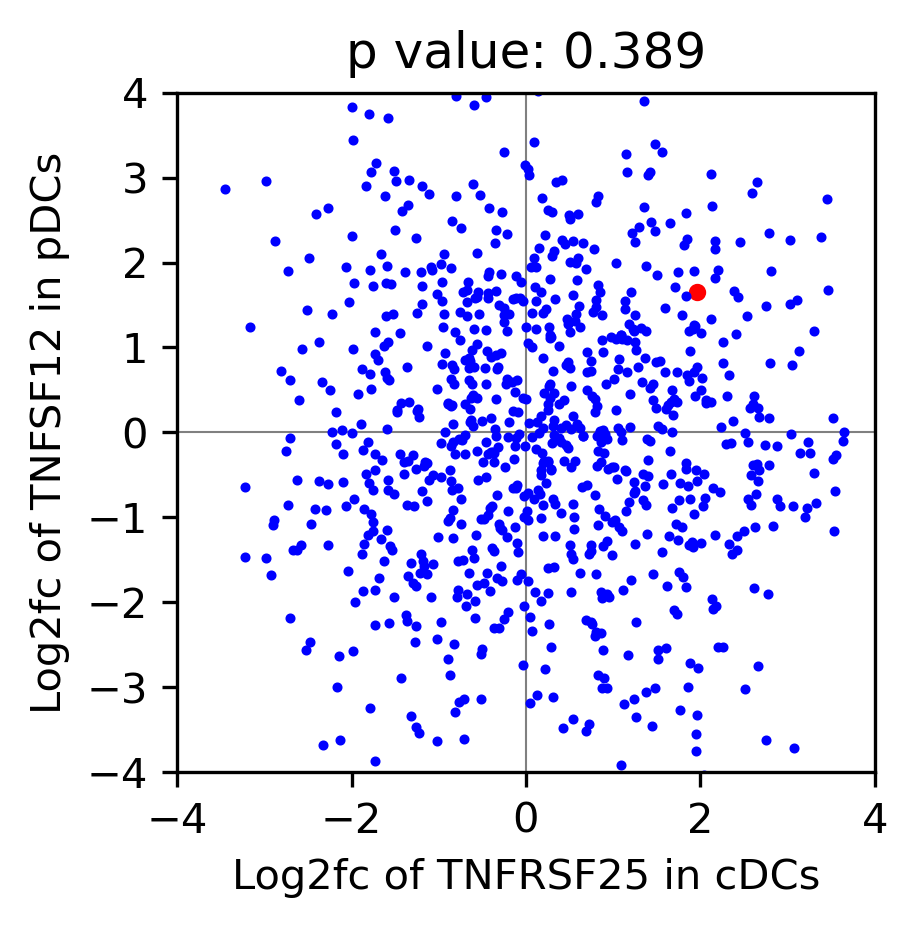

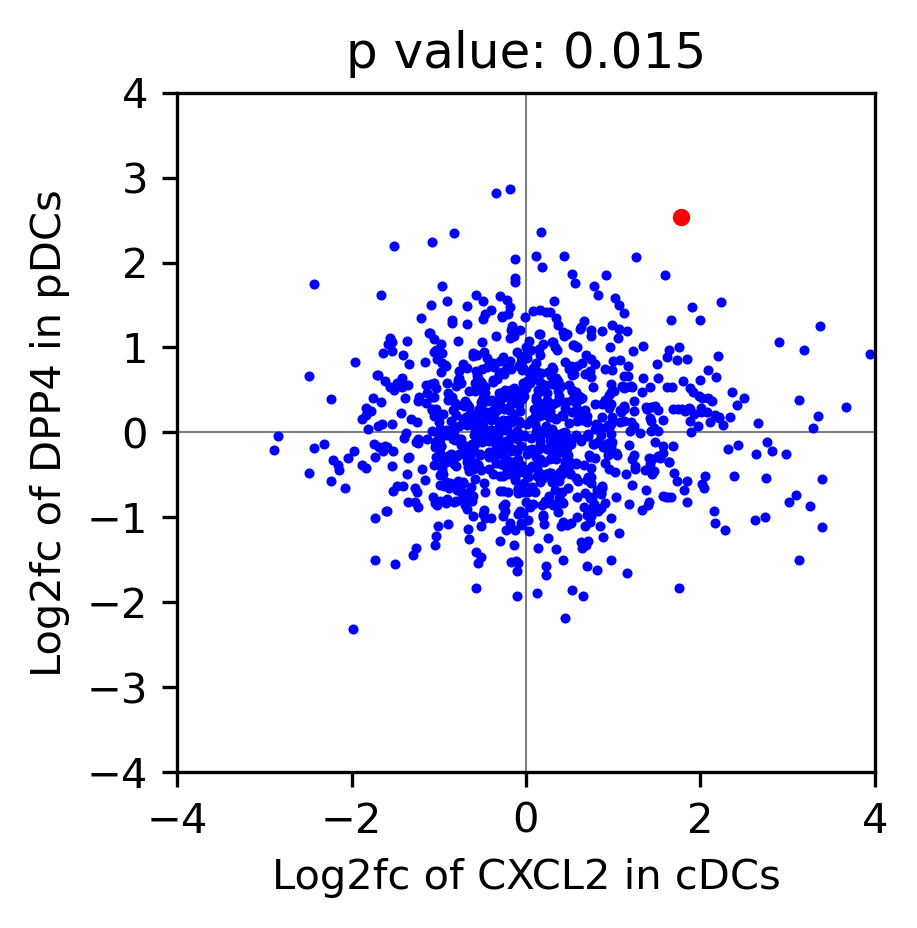

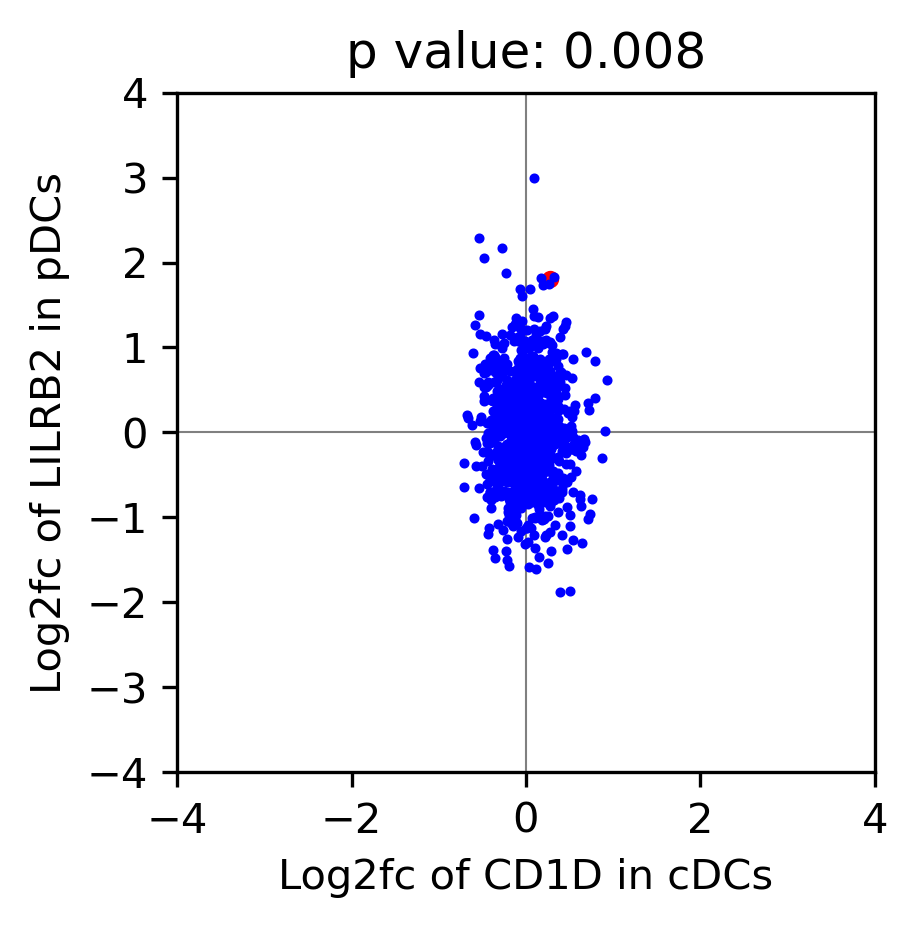

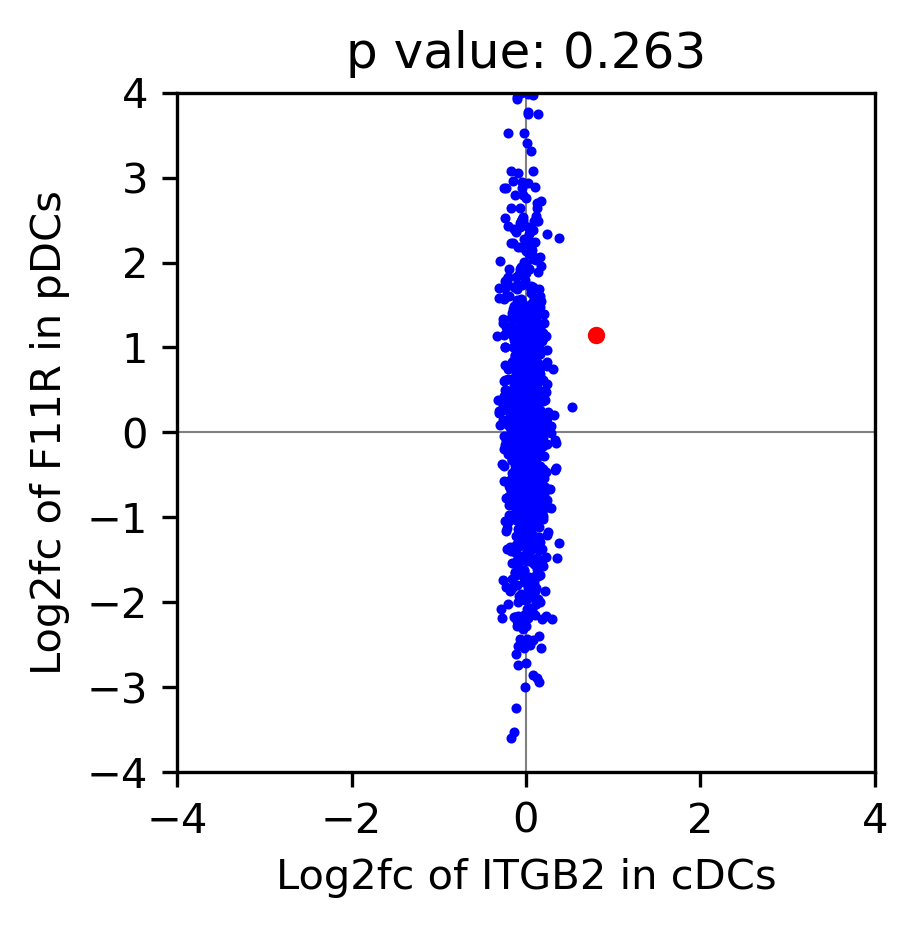

In [179]:
genes = [{ga: cta, gb : ctb} for ga, cta, gb, ctb in zip(up_up['ga'].tolist(), up_up['cta'].tolist(), up_up['gb'].tolist(), up_up['ctb'].tolist())]
res = pd.read_csv('/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/randomization_up_up.tsv', index_col=['ga', 'cta', 'gb', 'ctb']) 


fdn = '/home/yike/phd/dengue/data/excels/log2_fc/S_dengue_vs_dengue/20210625_figure_4_code/randomization/up_up/'
for inter in genes:
    fig, ax = plt.subplots(figsize=[3, 3], dpi=300)
    ga = list(inter.keys())[0]
    cta = inter[ga]
    gb = list(inter.keys())[1]
    ctb = inter[gb]
    
    log2fc = res.loc[ga, cta, gb, ctb]
    
    x0 = log2fc['log2fc_ga'].tolist()[0]
    y0 = log2fc['log2fc_gb'].tolist()[0]    

    x = log2fc['log2fc_ga'].tolist()[1:]
    y = log2fc['log2fc_gb'].tolist()[1:]

    ax.scatter(x0, y0, c='r', s=10)
    ax.scatter(x, y, c='blue', s=2)
    ax.axvline(0, c='gray', zorder=-3, lw=0.5)
    ax.axhline(0, c='gray', zorder=-3, lw=0.5)
    ax.set_ylim(-4, 4)
    ax.set_xlim(-4, 4)
    ax.set_xlabel('Log2fc of ' + ga + ' in ' + cta.replace('_', ' '))
    ax.set_ylabel('Log2fc of ' + gb + ' in ' + ctb.replace('_', ' '))
    p = res.loc[ga, cta, gb, ctb]['pvalue'][0]
    if p == 0:
        a = '< 0.001'
    else:
        a = str(p)
    ax.set_title('p value: ' + a)
    plt.savefig(fdn + ga + '_in_' + cta + '&' + gb + '_in_' + ctb + '.png', bbox_inches = 'tight')